In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB3, ResNet50, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
import tensorflow as tf
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")


In [3]:
# Define paths
train_data = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Image parameters
img_size = (224, 224)
batch_size = 16
img_shape = (img_size[0], img_size[1], 3)  # Adding channels for RGB

def load_data(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    return df

train_df = load_data(train_data)
test_df = load_data(test_data_dir)

# Split data into training, validation, and test sets
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'])


In [4]:
# Create data generators
tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                        color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                        color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [5]:
def create_cnn_model(img_shape, class_count):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=img_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(class_count, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [6]:
def create_ann_model(img_shape, class_count):
    model = Sequential([
        Flatten(input_shape=img_shape),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dense(class_count, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [7]:
def create_efficientnetb3_model(img_shape, class_count):
    base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
    model = Sequential([
        base_model,
        BatchNormalization(),
        Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu'),
        Dropout(0.45),
        Dense(class_count, activation='softmax')
    ])
    model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [8]:
def create_resnet50_model(img_shape, class_count):
    base_model = ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
    model = Sequential([
        base_model,
        BatchNormalization(),
        Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu'),
        Dropout(0.45),
        Dense(class_count, activation='softmax')
    ])
    model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [9]:
def create_vgg16_model(img_shape, class_count):
    base_model = VGG16(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
    model = Sequential([
        base_model,
        BatchNormalization(),
        Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu'),
        Dropout(0.45),
        Dense(class_count, activation='softmax')
    ])
    model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [10]:
def train_and_evaluate_model(model, model_name, train_gen, valid_gen, test_gen):
    epochs = 20
    
    # Train the model
    history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, verbose=1, shuffle=False)
    
    # Plot training history
    def plot_training(hist, model_name):
        tr_acc = hist.history['accuracy']
        tr_loss = hist.history['loss']
        val_acc = hist.history['val_accuracy']
        val_loss = hist.history['val_loss']
        index_loss = np.argmin(val_loss)
        val_lowest = val_loss[index_loss]
        index_acc = np.argmax(val_acc)
        acc_highest = val_acc[index_acc]
        epochs = [i+1 for i in range(len(tr_acc))]
        loss_label = f'best epoch= {str(index_loss + 1)}'
        acc_label = f'best epoch= {str(index_acc + 1)}'

        plt.figure(figsize=(20, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, tr_loss, 'r', label='Training loss')
        plt.plot(epochs, val_loss, 'g', label='Validation loss')
        plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
        plt.title(f'{model_name} - Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, tr_acc, 'r', label='Training Accuracy')
        plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
        plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
        plt.title(f'{model_name} - Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    plot_training(history, model_name)

    # Evaluate the model
    test_score = model.evaluate(test_gen, verbose=1)
    print(f"{model_name} - Test Loss: {test_score[0]}")
    print(f"{model_name} - Test Accuracy: {test_score[1]}")

    # Get predictions
    y_pred = model.predict(test_gen)
    y_pred_classes = np.argmax(y_pred, axis=1)
    true_classes = test_gen.classes

    # Compute metrics
    conf_matrix = confusion_matrix(true_classes, y_pred_classes)
    print(f"{model_name} - Confusion Matrix:\n", conf_matrix)
    print(f"{model_name} - Classification Report:\n", classification_report(true_classes, y_pred_classes, target_names=test_gen.class_indices.keys()))

    return history


Number of classes: 4
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training CNN...

Epoch 1/20


I0000 00:00:1729179445.531993     111 service.cc:145] XLA service 0x79807001c040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729179445.532054     111 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729179445.532059     111 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  3/286 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.1736 - loss: 3.7220 

I0000 00:00:1729179453.669151     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


286/286 ━━━━━━━━━━━━━━━━━━━━ 46s 126ms/step - accuracy: 0.5878 - loss: 1.0878 - val_accuracy: 0.8469 - val_loss: 0.4223
Epoch 2/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.8411 - loss: 0.4291 - val_accuracy: 0.8863 - val_loss: 0.3732
Epoch 3/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9064 - loss: 0.2600 - val_accuracy: 0.9221 - val_loss: 0.2377
Epoch 4/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.9455 - loss: 0.1460 - val_accuracy: 0.9178 - val_loss: 0.2427
Epoch 5/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9646 - loss: 0.1083 - val_accuracy: 0.9046 - val_loss: 0.3411
Epoch 6/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.9643 - loss: 0.1036 - val_accuracy: 0.9458 - val_loss: 0.1814
Epoch 7/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9857 - loss: 0.0432 - val_accuracy: 0.9335 - val_loss: 0.2610
Epoch 8/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.9839 - loss: 0.0453 - val_accura

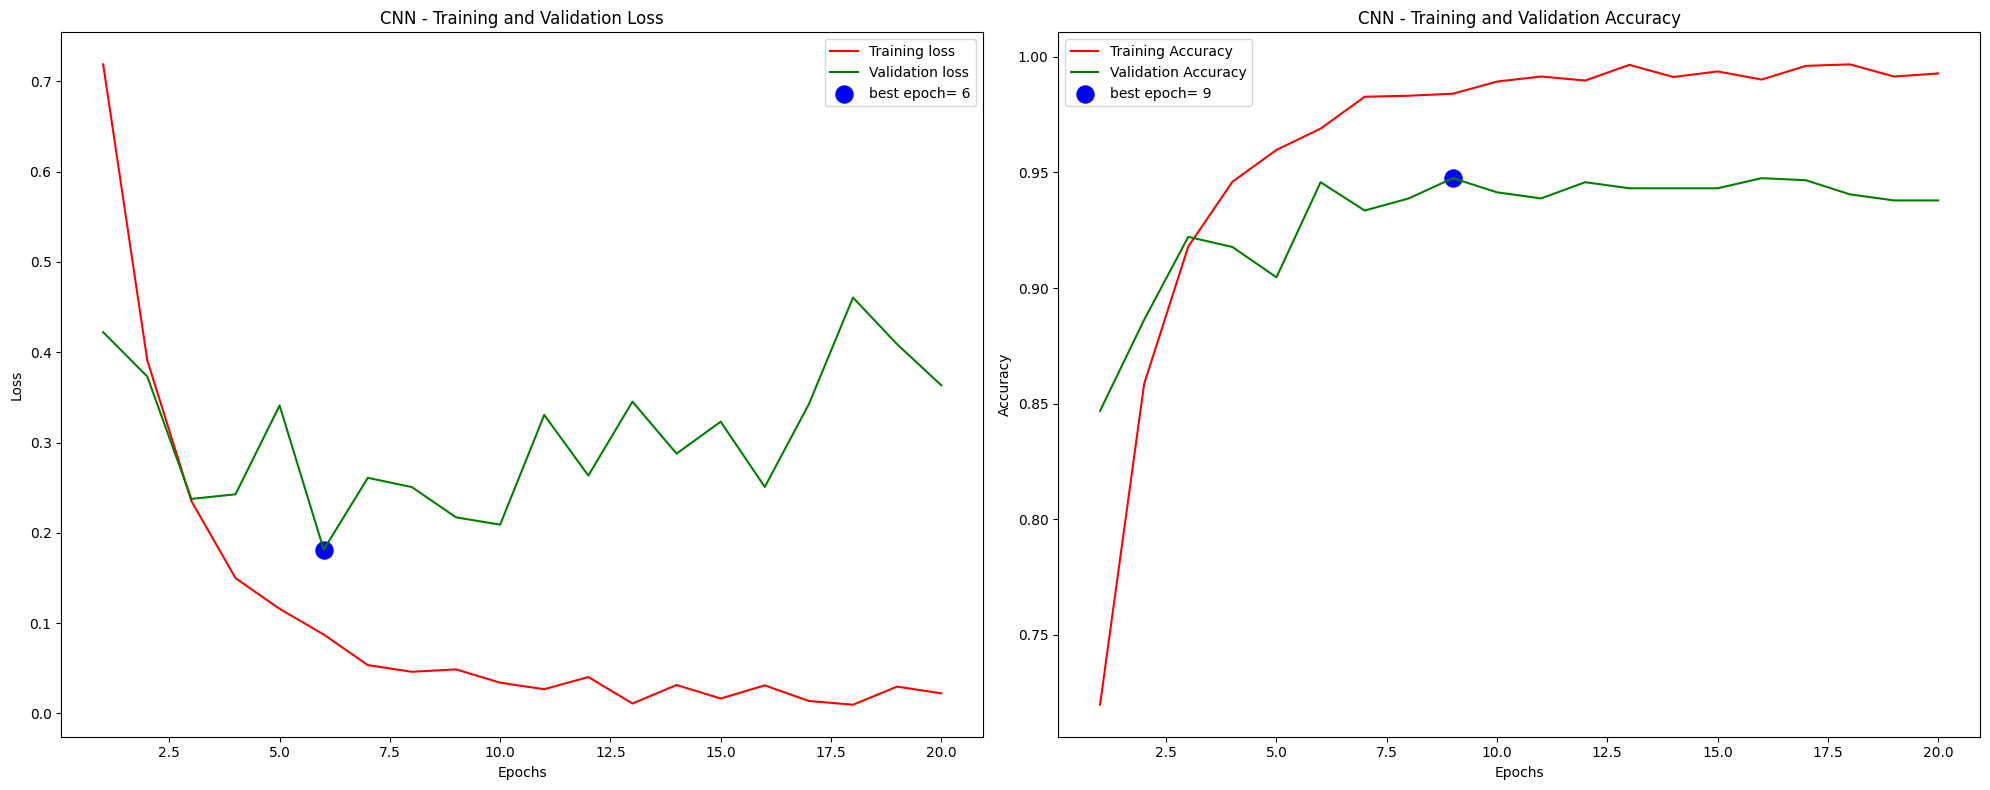

82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.9713 - loss: 0.1547
CNN - Test Loss: 0.3042393922805786
CNN - Test Accuracy: 0.9450801014900208
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
CNN - Confusion Matrix:
 [[284  16   0   0]
 [ 16 260  16  14]
 [  3   3 398   1]
 [  1   2   0 297]]
CNN - Classification Report:
               precision    recall  f1-score   support

      glioma       0.93      0.95      0.94       300
  meningioma       0.93      0.85      0.89       306
     notumor       0.96      0.98      0.97       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.95      0.94      1311


Training ANN...

Epoch 1/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.3820 - loss: 13.6481 - val_accuracy: 0.5582 - val_loss: 1.0700
Epoch 2/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.4659 - loss: 1.2025 - val_

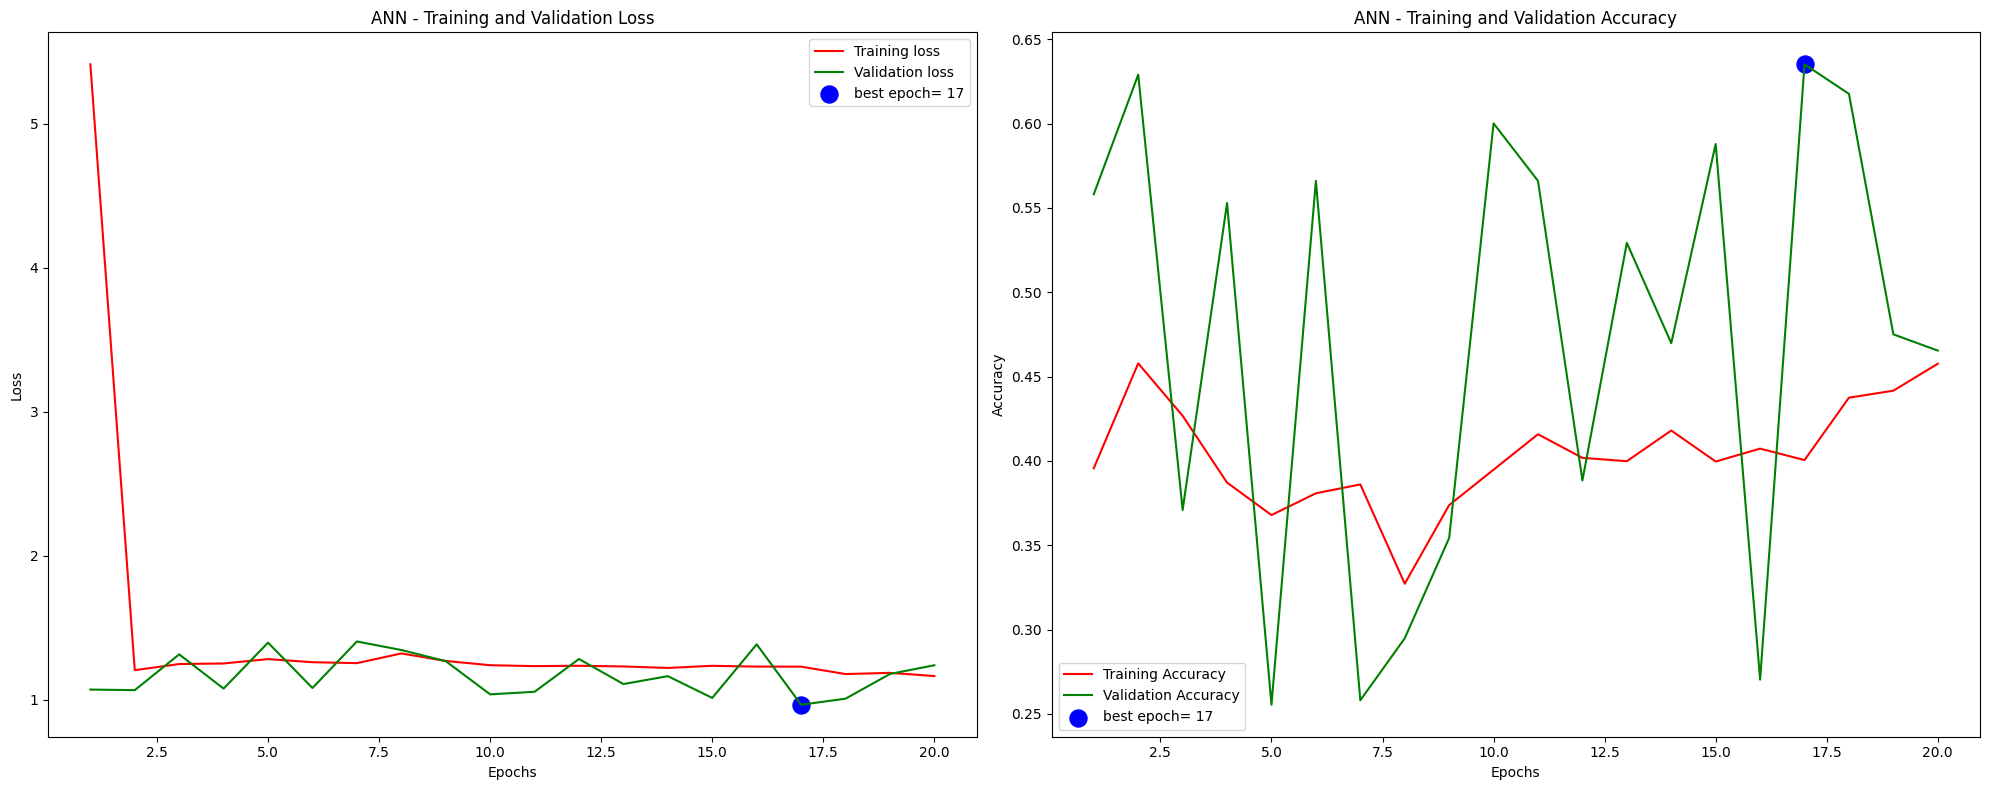

82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6830 - loss: 1.1762
ANN - Test Loss: 1.2958892583847046
ANN - Test Accuracy: 0.4408848285675049
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
ANN - Confusion Matrix:
 [[131   0   0 169]
 [106   0   5 195]
 [238   1 147  19]
 [  0   0   0 300]]
ANN - Classification Report:
               precision    recall  f1-score   support

      glioma       0.28      0.44      0.34       300
  meningioma       0.00      0.00      0.00       306
     notumor       0.97      0.36      0.53       405
   pituitary       0.44      1.00      0.61       300

    accuracy                           0.44      1311
   macro avg       0.42      0.45      0.37      1311
weighted avg       0.46      0.44      0.38      1311


Training EfficientNetB3...

Epoch 1/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 273s 478ms/step - accuracy: 0.5416 - loss: 11.5903 - val_accuracy: 0.2791 - val_loss: 6.1963
Epoch 2/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 43s 149ms/step - accuracy: 0.3820 - loss:

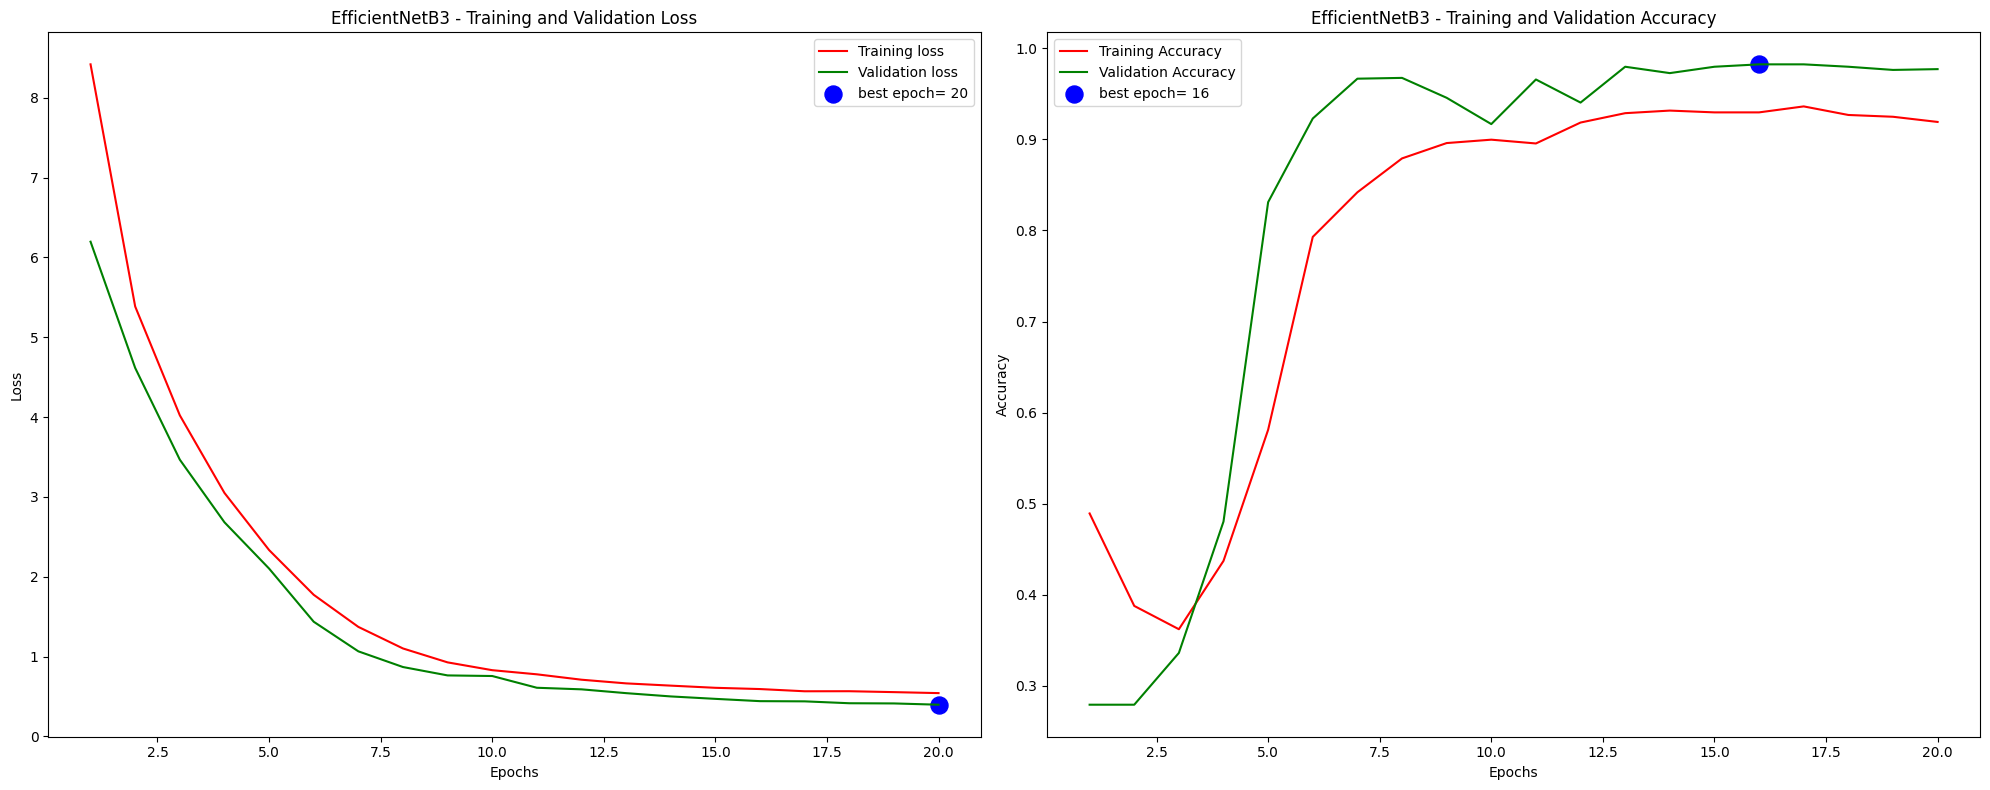

82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.9903 - loss: 0.3619
EfficientNetB3 - Test Loss: 0.3806360363960266
EfficientNetB3 - Test Accuracy: 0.9816933870315552
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step
EfficientNetB3 - Confusion Matrix:
 [[292   8   0   0]
 [  1 296   3   6]
 [  0   1 400   4]
 [  0   1   0 299]]
EfficientNetB3 - Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      0.97      0.98       300
  meningioma       0.97      0.97      0.97       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.97      1.00      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311


Training ResNet50...

Epoch 1/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 130s 268ms/step - accuracy: 0.6569 - loss: 11.5435 - val_accuracy: 0.2555 - val_loss: 6.4738
Epoch 2/20
286/286 ━━━━━━━━━━━━━━━━━━━━

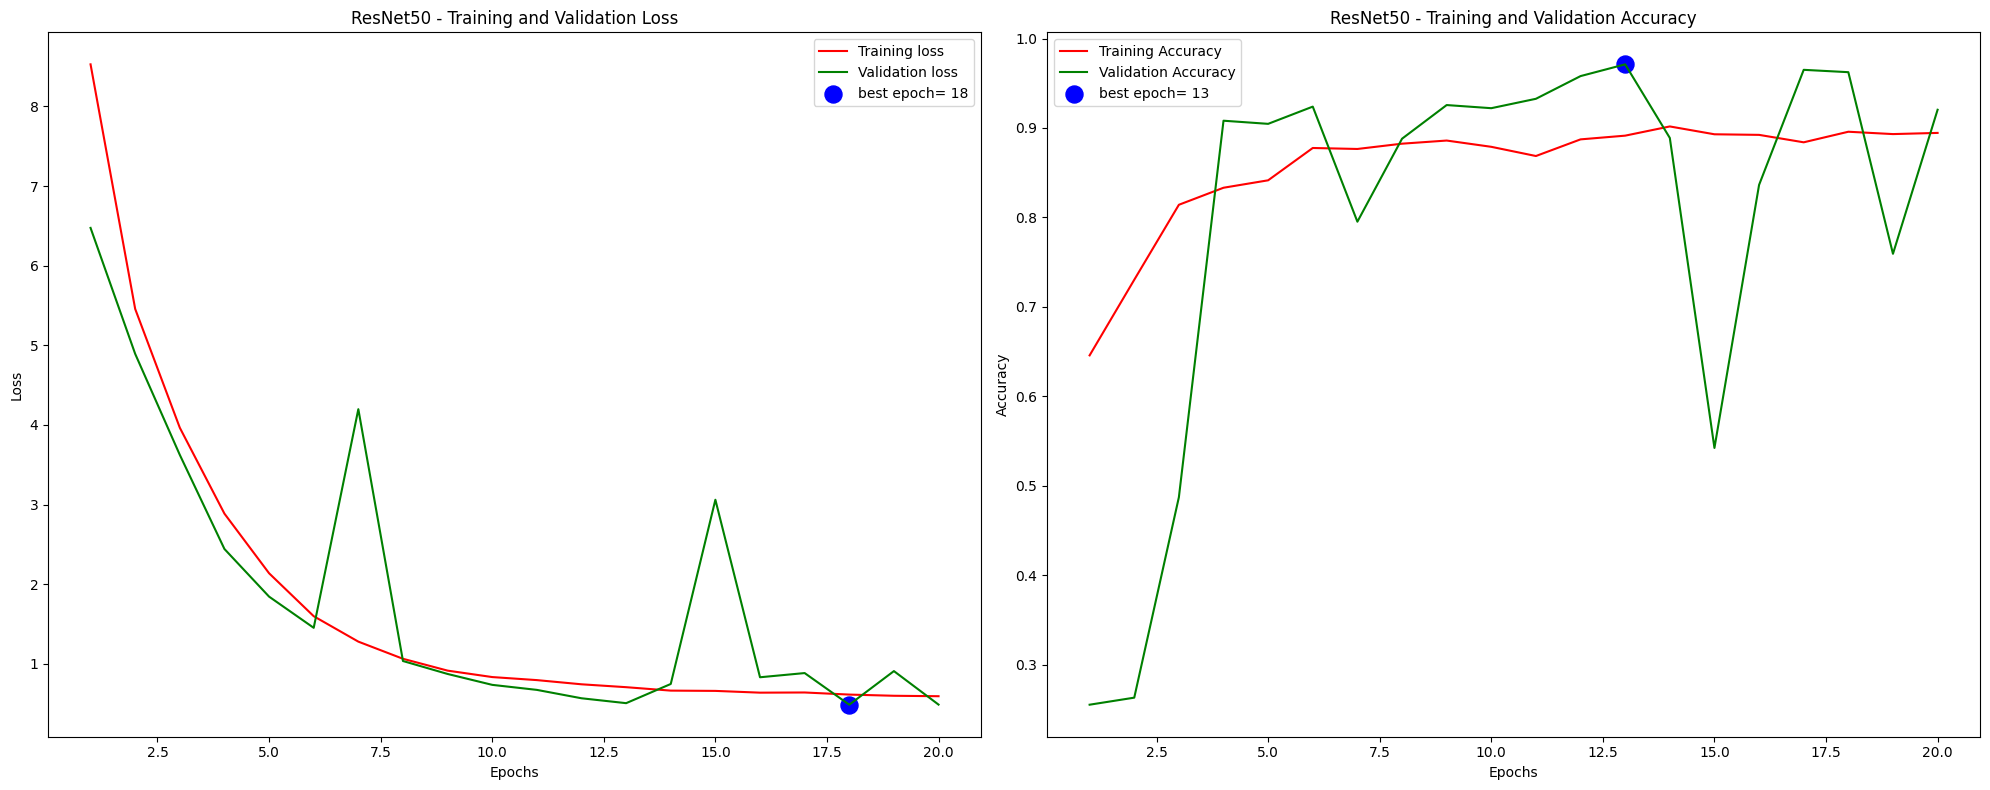

82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.9408 - loss: 0.4364
ResNet50 - Test Loss: 0.493743360042572
ResNet50 - Test Accuracy: 0.9176201224327087
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step
ResNet50 - Confusion Matrix:
 [[265  28   3   4]
 [  0 299   4   3]
 [  0  64 341   0]
 [  0   2   0 298]]
ResNet50 - Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      0.88      0.94       300
  meningioma       0.76      0.98      0.86       306
     notumor       0.98      0.84      0.91       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.92      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.92      0.92      1311


Training VGG16...

Epoch 1/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 124s 319ms/step - accuracy: 0.4594 - loss: 6.3890 - val_accuracy: 0.4392 - val_loss: 4.7546
Epoch 2/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 65s 229ms/step - accuracy: 0.43

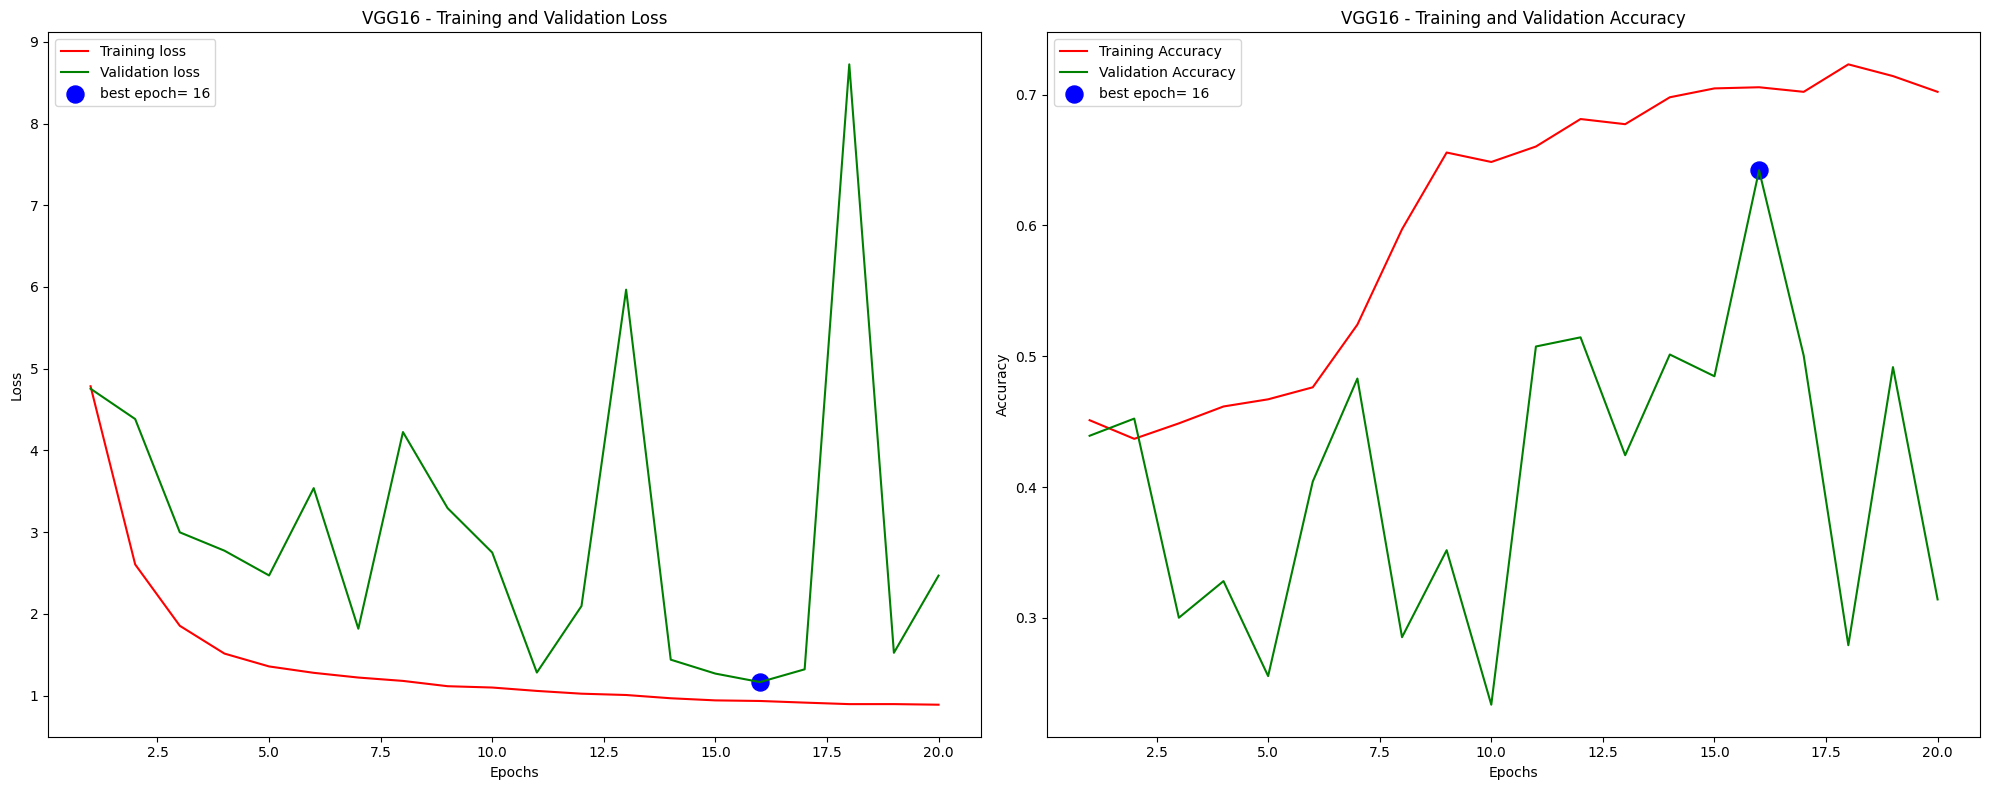

82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - accuracy: 0.6425 - loss: 1.5925
VGG16 - Test Loss: 2.573373556137085
VGG16 - Test Accuracy: 0.3142639100551605
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step
VGG16 - Confusion Matrix:
 [[  0   0   0 300]
 [  0   2   2 302]
 [  0   0 110 295]
 [  0   0   0 300]]
VGG16 - Classification Report:
               precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       1.00      0.01      0.01       306
     notumor       0.98      0.27      0.43       405
   pituitary       0.25      1.00      0.40       300

    accuracy                           0.31      1311
   macro avg       0.56      0.32      0.21      1311
weighted avg       0.59      0.31      0.23      1311



In [11]:
# Calculate the number of unique classes
class_count = len(train_df['labels'].unique())
print(f"Number of classes: {class_count}")

# List of models
models = {
    'CNN': create_cnn_model(img_shape, class_count),
    'ANN': create_ann_model(img_shape, class_count),
    'EfficientNetB3': create_efficientnetb3_model(img_shape, class_count),
    'ResNet50': create_resnet50_model(img_shape, class_count),
    'VGG16': create_vgg16_model(img_shape, class_count)
}

# Store histories for plotting
histories = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...\n")
    history = train_and_evaluate_model(model, model_name, train_gen, valid_gen, test_gen)
    histories[model_name] = history


    

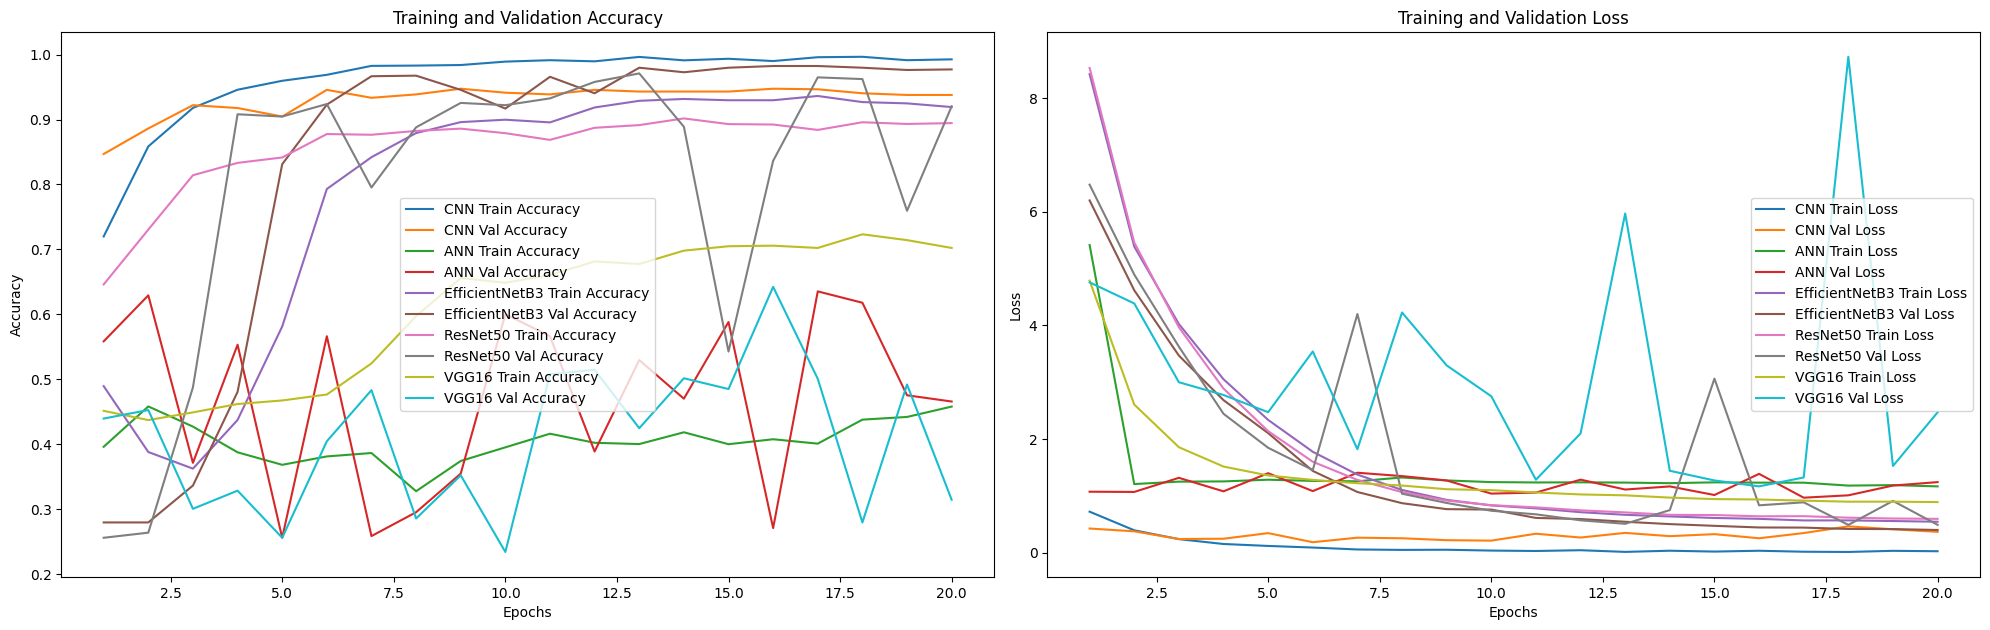

In [12]:
def plot_all_models_histories(histories):
    plt.figure(figsize=(20, 12))

    for model_name, hist in histories.items():
        epochs = [i+1 for i in range(len(hist.history['accuracy']))]
        plt.subplot(2, 2, 1)
        plt.plot(epochs, hist.history['accuracy'], label=f'{model_name} Train Accuracy')
        plt.plot(epochs, hist.history['val_accuracy'], label=f'{model_name} Val Accuracy')
        
        plt.subplot(2, 2, 2)
        plt.plot(epochs, hist.history['loss'], label=f'{model_name} Train Loss')
        plt.plot(epochs, hist.history['val_loss'], label=f'{model_name} Val Loss')

    plt.subplot(2, 2, 1)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_all_models_histories(histories)


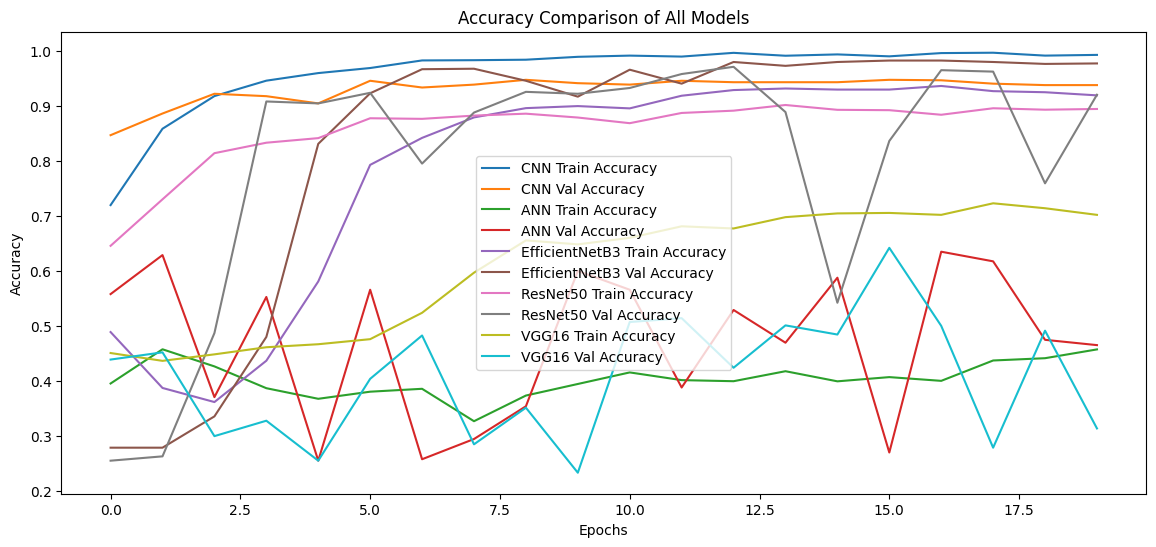

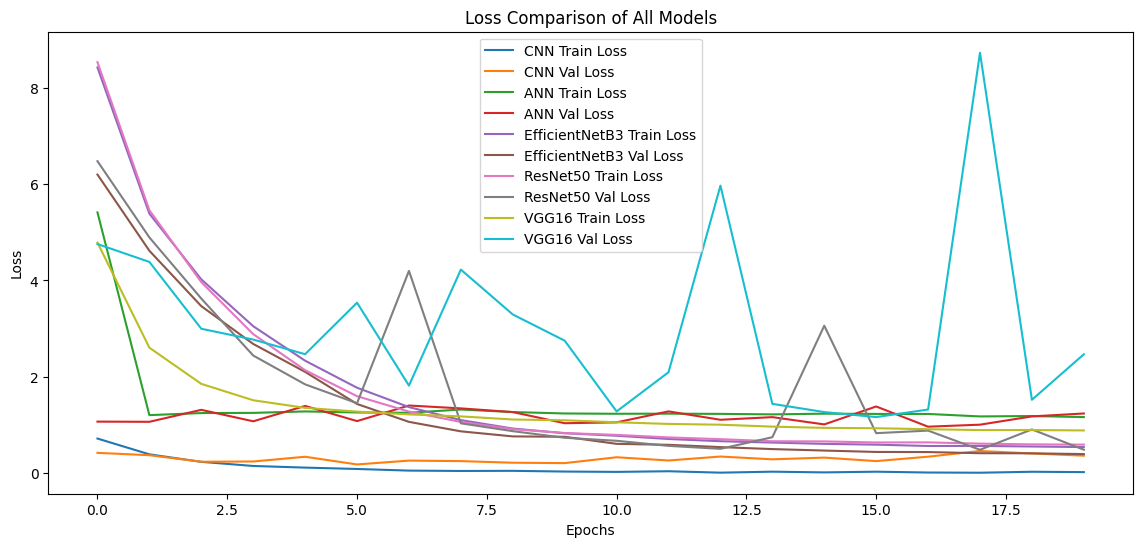

In [13]:
import matplotlib.pyplot as plt

def plot_all_accuracies(histories):
    plt.figure(figsize=(14, 6))
    
    for model_name, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{model_name} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{model_name} Val Accuracy')
    
    plt.title('Accuracy Comparison of All Models')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_all_losses(histories):
    plt.figure(figsize=(14, 6))
    
    for model_name, history in histories.items():
        plt.plot(history.history['loss'], label=f'{model_name} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{model_name} Val Loss')
    
    plt.title('Loss Comparison of All Models')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Example usage
plot_all_accuracies(histories)
plot_all_losses(histories)


Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.
Epoch 1/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 103s 193ms/step - accuracy: 0.2922 - loss: 2.6478 - val_accuracy: 0.3788 - val_loss: 1.3397
Epoch 2/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.3400 - loss: 1.8583 - val_accuracy: 0.3823 - val_loss: 1.2819
Epoch 3/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.3714 - loss: 1.4396 - val_accuracy: 0.5258 - val_loss: 1.2574
Epoch 4/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.3597 - loss: 1.3472 - val_accuracy: 0.3920 - val_loss: 1.2642
Epoch 5/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.3651 - loss: 1.3175 - val_accuracy: 0.3771 - val_loss: 1.2622
Epoch 6/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.3787 - loss: 1.2884 - val_accuracy: 0.4392 - val_loss: 1.2664
Epoch 7/50
286/286 ━━━━━━━━━━━━━━━━

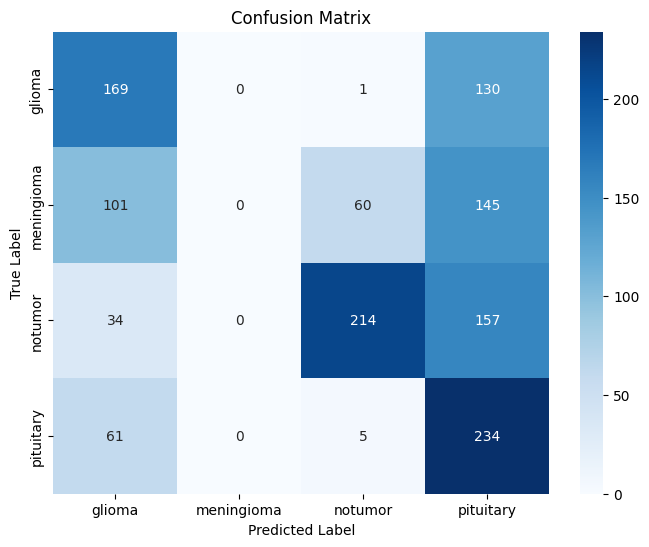

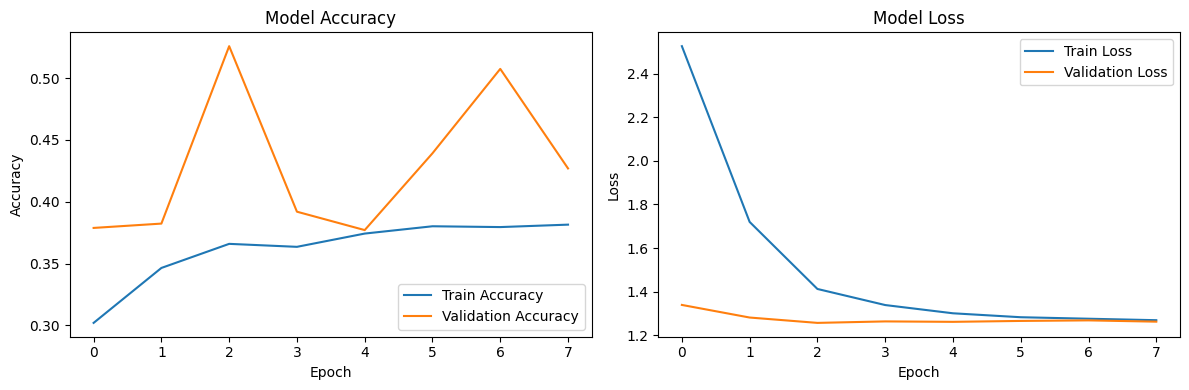

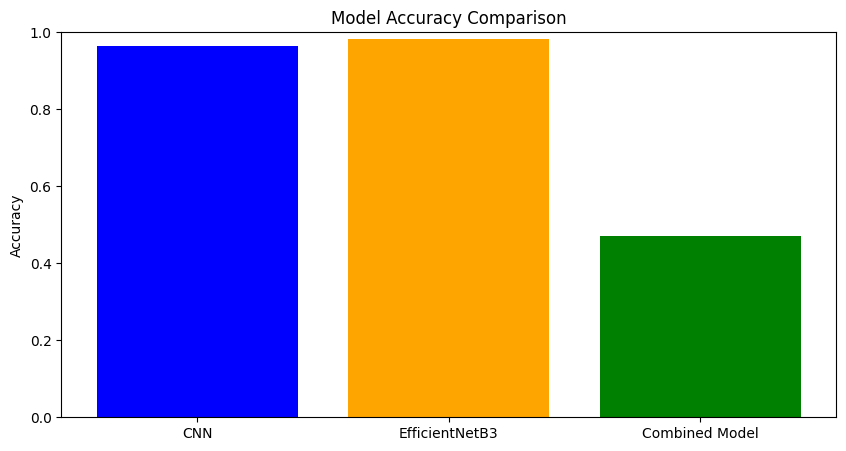

In [32]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
train_data = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Image parameters
img_size = (224, 224)
batch_size = 16

def load_data(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    return df

train_df = load_data(train_data)
test_df = load_data(test_data_dir)

# Split data into training, validation, and test sets
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'])

# Create data generators
tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', 
                                        target_size=img_size, class_mode='categorical',
                                        color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', 
                                        target_size=img_size, class_mode='categorical',
                                        color_mode='rgb', shuffle=False, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', 
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=False, batch_size=batch_size)

# Build the combined model
def build_combined_model():
    base_model = EfficientNetB3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4, activation='softmax'))  # Assuming 4 classes for brain tumor types

    return model

combined_model = build_combined_model()
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = combined_model.fit(train_gen, 
                              epochs=50, 
                              validation_data=valid_gen,
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                                                         restore_best_weights=True)])

# Evaluate the model on the test dataset
test_loss, test_accuracy = combined_model.evaluate(test_gen)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Generate predictions
y_pred = combined_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

# Confusion Matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
def plot_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# Comparison of models
# Collecting previous models' results
models_names = ['CNN', 'EfficientNetB3', 'Combined Model']
results = [0.9634, 0.9832, test_accuracy]  # Assuming previous results were stored

# Bar graph for comparison
plt.figure(figsize=(10, 5))
plt.bar(models_names, results, color=['blue', 'orange', 'green'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()


Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ ?                      │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,783,535 (41.14 MB)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729191282.905034     105 service.cc:145] XLA service 0x7f804c001350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729191282.905084     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729191282.905088     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/286 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.1406 - loss: 2.1408   

I0000 00:00:1729191321.953193     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


286/286 ━━━━━━━━━━━━━━━━━━━━ 186s 448ms/step - accuracy: 0.2509 - loss: 1.4403 - val_accuracy: 0.2345 - val_loss: 1.4069
Epoch 2/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 60s 205ms/step - accuracy: 0.2912 - loss: 1.3780 - val_accuracy: 0.2703 - val_loss: 1.3777
Epoch 3/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 60s 205ms/step - accuracy: 0.2968 - loss: 1.3711 - val_accuracy: 0.2791 - val_loss: 1.3773
Epoch 4/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 59s 200ms/step - accuracy: 0.3110 - loss: 1.3646 - val_accuracy: 0.2835 - val_loss: 1.3606
Epoch 5/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 58s 199ms/step - accuracy: 0.3190 - loss: 1.3457 - val_accuracy: 0.3088 - val_loss: 1.3507
Epoch 6/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 58s 198ms/step - accuracy: 0.3187 - loss: 1.3343 - val_accuracy: 0.2598 - val_loss: 1.3777
Epoch 7/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 58s 199ms/step - accuracy: 0.3267 - loss: 1.3308 - val_accuracy: 0.2791 - val_loss: 1.4090
Epoch 8/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 58s 196ms/step - accuracy: 0.3564 - loss: 1.3089 - va

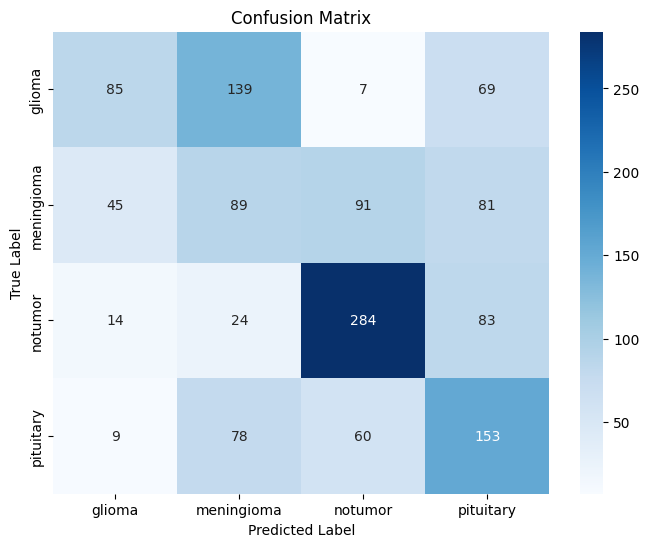

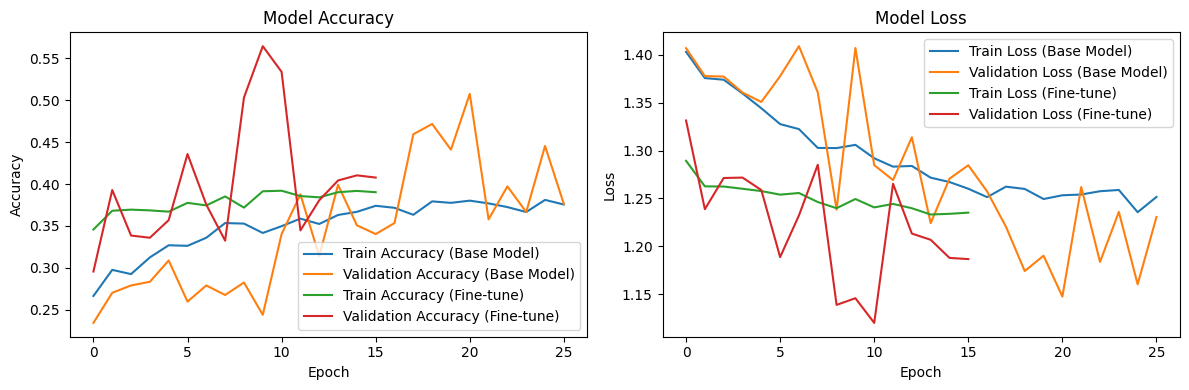

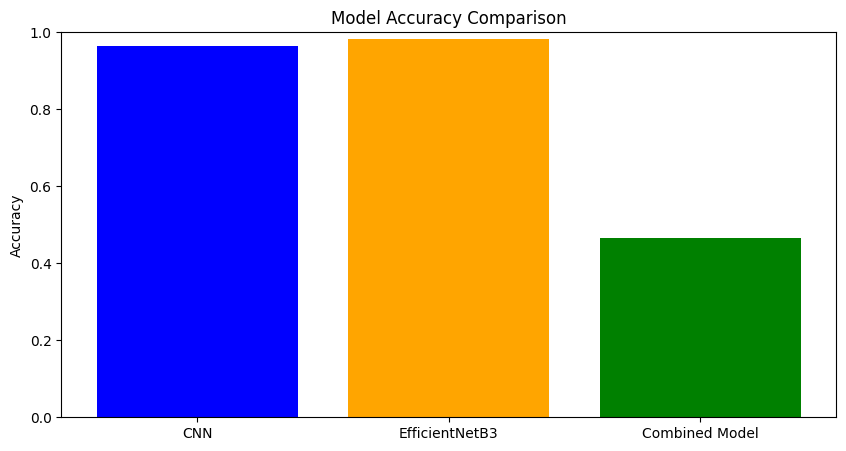

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
train_data = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Image parameters
img_size = (224, 224)  # Keep the input size as 224x224
batch_size = 16

def load_data(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    return df

train_df = load_data(train_data)
test_df = load_data(test_data_dir)

# Split data into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'])

# Create data generators
tr_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                             height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                             horizontal_flip=True, fill_mode='nearest')

ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', 
                                        target_size=img_size, class_mode='categorical',
                                        color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', 
                                        target_size=img_size, class_mode='categorical',
                                        color_mode='rgb', shuffle=False, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', 
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=False, batch_size=batch_size)

# Load EfficientNetB3 with ImageNet weights, excluding top layers
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers for feature extraction
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential()

# Add EfficientNetB3 base model
model.add(base_model)

# Add a few simple CNN layers
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Global average pooling
model.add(layers.GlobalAveragePooling2D())

# Fully connected layers with dropout
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))

# Output layer for 4-class classification
model.add(layers.Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
history = model.fit(train_gen, 
                    epochs=50, 
                    validation_data=valid_gen,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                                               restore_best_weights=True)])

# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers[-10:]:  # Fine-tune the last 10 layers
    layer.trainable = True

# Compile the model again
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training with fine-tuning
fine_tune_history = model.fit(train_gen, 
                              epochs=20, 
                              validation_data=valid_gen,
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                                                         restore_best_weights=True)])

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Generate predictions
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

# Confusion Matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
def plot_history(history, fine_tune_history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy (Base Model)')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Base Model)')
    plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy (Fine-tune)')
    plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy (Fine-tune)')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss (Base Model)')
    plt.plot(history.history['val_loss'], label='Validation Loss (Base Model)')
    plt.plot(fine_tune_history.history['loss'], label='Train Loss (Fine-tune)')
    plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss (Fine-tune)')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history, fine_tune_history)

# Comparison of models (replace with actual previous models' accuracy)
models_names = ['CNN', 'EfficientNetB3', 'Combined Model']
results = [0.9634, 0.9832, test_accuracy]  # Previous results for comparison

# Bar graph for comparison
plt.figure(figsize=(10, 5))
plt.bar(models_names, results, color=['blue', 'orange', 'green'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()


Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ ?                      │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,783,535 (41.14 MB)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


572/572 ━━━━━━━━━━━━━━━━━━━━ 172s 208ms/step - accuracy: 0.2547 - loss: 1.5592 - val_accuracy: 0.2791 - val_loss: 1.3861
Epoch 2/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 70s 122ms/step - accuracy: 0.2723 - loss: 1.3865 - val_accuracy: 0.2791 - val_loss: 1.3779
Epoch 3/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 70s 122ms/step - accuracy: 0.2878 - loss: 1.3841 - val_accuracy: 0.2791 - val_loss: 1.3853
Epoch 4/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 70s 121ms/step - accuracy: 0.3001 - loss: 1.3857 - val_accuracy: 0.2791 - val_loss: 1.3842
Epoch 5/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 71s 122ms/step - accuracy: 0.2826 - loss: 1.3860 - val_accuracy: 0.2791 - val_loss: 1.3847
Epoch 6/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 71s 122ms/step - accuracy: 0.2759 - loss: 1.3850 - val_accuracy: 0.2791 - val_loss: 1.3845
Epoch 7/50
572/572 ━━━━━━━━━━━━━━━━━━━━ 73s 126ms/step - accuracy: 0.2772 - loss: 1.3843 - val_accuracy: 0.2791 - val_loss: 1.3843
Epoch 1/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 196s 228ms/step - accuracy: 0.2732 - loss: 1.5465 - v

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.3513 - loss: 1.1671
Test Loss: 1.2600525617599487
Test Accuracy: 0.3142639100551605
164/164 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.00      0.00      0.00       306
     notumor       0.37      0.94      0.53       405
   pituitary       0.12      0.11      0.11       300

    accuracy                           0.31      1311
   macro avg       0.12      0.26      0.16      1311
weighted avg       0.14      0.31      0.19      1311



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


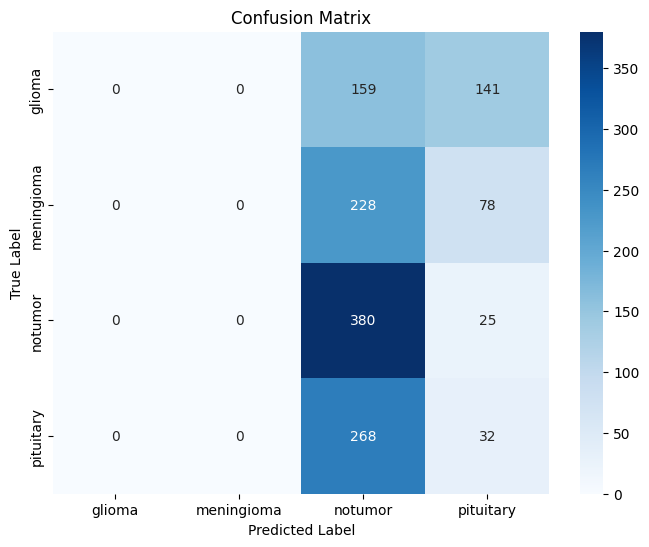

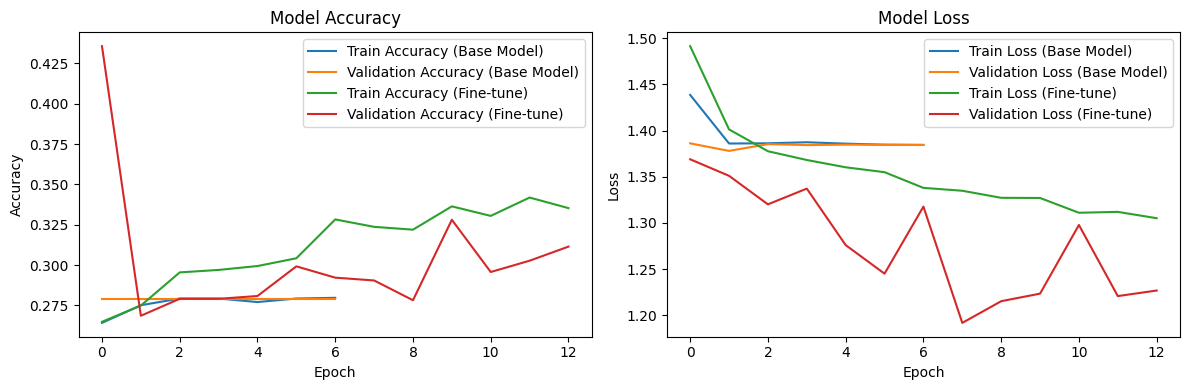

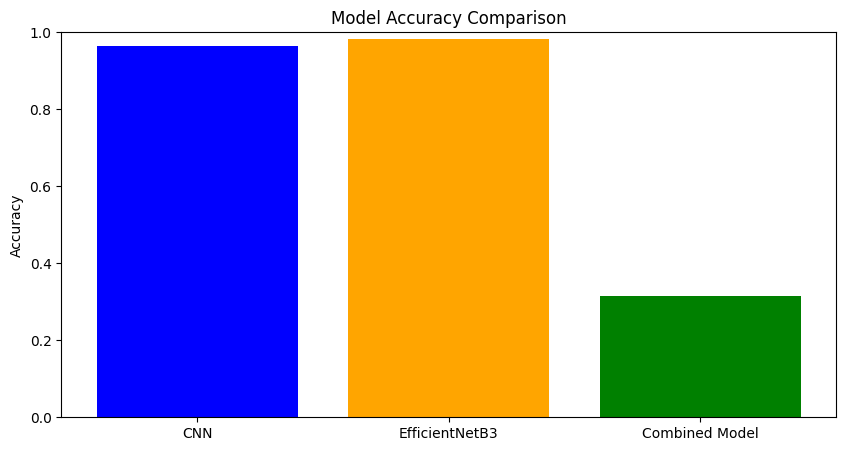

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight

# Define paths
train_data = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Image parameters
img_size = (224, 224)  # Keep the input size as 224x224
batch_size = 8  # Experiment with a smaller batch size

# Load data function
def load_data(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    return df

# Load datasets
train_df = load_data(train_data)
test_df = load_data(test_data_dir)

# Split data into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'])

# Enhanced data augmentation
tr_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30, 
    width_shift_range=0.3, 
    height_shift_range=0.3, 
    shear_range=0.3, 
    zoom_range=0.3, 
    brightness_range=[0.8, 1.2],  # Vary brightness
    horizontal_flip=True, 
    fill_mode='nearest'
)

# Test generator
ts_gen = ImageDataGenerator(rescale=1./255)

# Data generators
train_gen = tr_gen.flow_from_dataframe(
    train_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=True, 
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False, 
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False, 
    batch_size=batch_size
)

# Load EfficientNetB3 base model (excluding top layers)
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential()

# Add EfficientNetB3 base model
model.add(base_model)

# Add additional CNN layers to improve feature extraction
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Global average pooling
model.add(layers.GlobalAveragePooling2D())

# Fully connected layers with dropout
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))  # Increase dropout for regularization

# Output layer for 4-class classification
model.add(layers.Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Train the model (base model frozen)
history = model.fit(
    train_gen, 
    epochs=50, 
    validation_data=valid_gen,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Unfreeze more layers of the base model for fine-tuning (last 50 layers)
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Compile the model again for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Add a learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)



# Compute class weights using keyword arguments
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Keyword argument
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))


# Fine-tune the model with class weights and learning rate scheduler
fine_tune_history = model.fit(
    train_gen, 
    epochs=20, 
    validation_data=valid_gen,
    class_weight=class_weights,  # Using class weights
    callbacks=[lr_scheduler, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Generate predictions
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

# Confusion Matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
def plot_history(history, fine_tune_history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy (Base Model)')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Base Model)')
    plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy (Fine-tune)')
    plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy (Fine-tune)')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss (Base Model)')
    plt.plot(history.history['val_loss'], label='Validation Loss (Base Model)')
    plt.plot(fine_tune_history.history['loss'], label='Train Loss (Fine-tune)')
    plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss (Fine-tune)')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history, fine_tune_history)

# Comparison of models (replace with actual previous models' accuracy)
models_names = ['CNN', 'EfficientNetB3', 'Combined Model']
results = [0.9634, 0.9832, test_accuracy]  # Previous results for comparison

# Bar graph for comparison
plt.figure(figsize=(10, 5))
plt.bar(models_names, results, color=['blue', 'orange', 'green'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()


Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training CNN model...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729239033.822043     108 service.cc:145] XLA service 0x78799c005800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729239033.822111     108 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729239033.822116     108 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/286 ━━━━━━━━━━━━━━━━━━━━ 59:05 12s/step - accuracy: 0.1250 - loss: 1.3884

I0000 00:00:1729239041.890002     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


286/286 ━━━━━━━━━━━━━━━━━━━━ 107s 331ms/step - accuracy: 0.4599 - loss: 1.2304 - val_accuracy: 0.6107 - val_loss: 0.8906
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 66s 226ms/step - accuracy: 0.6503 - loss: 0.8719 - val_accuracy: 0.6194 - val_loss: 0.8574
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 66s 225ms/step - accuracy: 0.6867 - loss: 0.7590 - val_accuracy: 0.7979 - val_loss: 0.5483
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 66s 226ms/step - accuracy: 0.7263 - loss: 0.6736 - val_accuracy: 0.7979 - val_loss: 0.5524
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 66s 227ms/step - accuracy: 0.7514 - loss: 0.6416 - val_accuracy: 0.8014 - val_loss: 0.4784
Epoch 6/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 66s 225ms/step - accuracy: 0.7632 - loss: 0.6289 - val_accuracy: 0.8224 - val_loss: 0.4700
Epoch 7/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 66s 226ms/step - accuracy: 0.7711 - loss: 0.5857 - val_accuracy: 0.8101 - val_loss: 0.5305
Epoch 8/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 66s 226ms/step - accuracy: 0.7745 - loss: 0.5618 - va

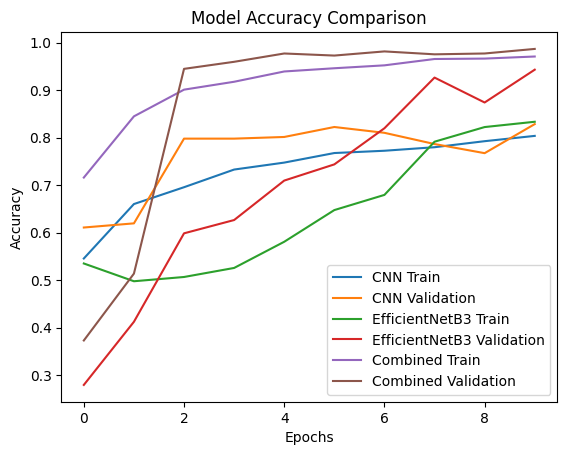

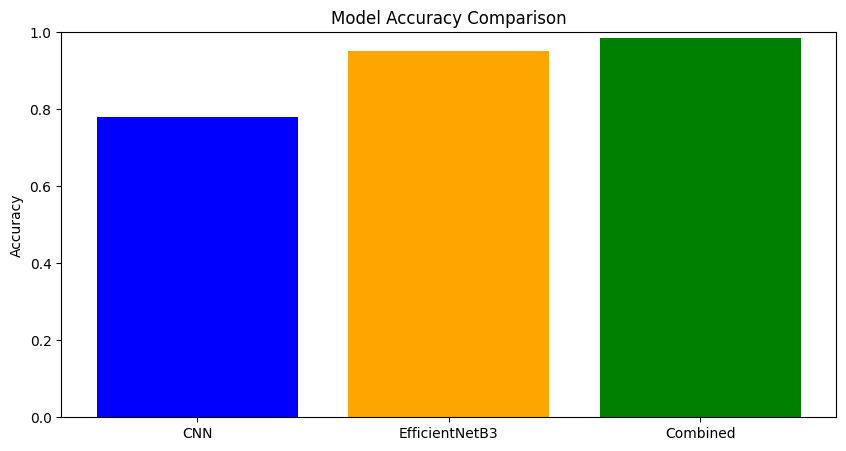

Classification Report for CNN:
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
              precision    recall  f1-score   support

      glioma       0.88      0.62      0.73       300
  meningioma       0.61      0.51      0.55       306
     notumor       0.77      0.99      0.87       405
   pituitary       0.86      0.93      0.89       300

    accuracy                           0.78      1311
   macro avg       0.78      0.76      0.76      1311
weighted avg       0.78      0.78      0.77      1311



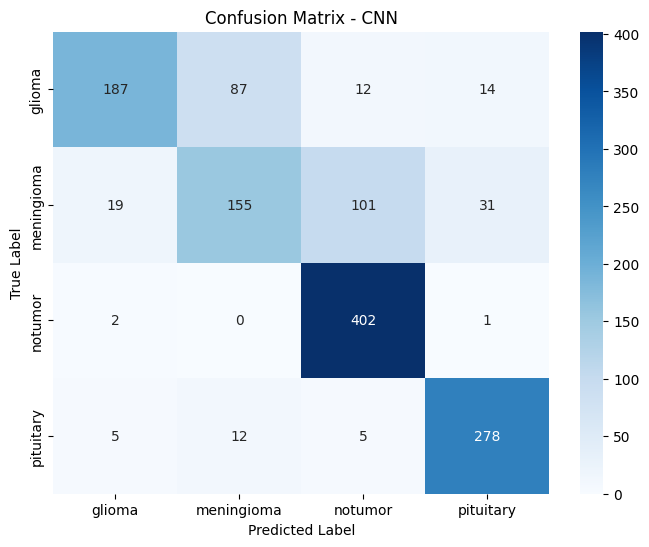

Classification Report for EfficientNetB3:
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step
              precision    recall  f1-score   support

      glioma       0.90      0.99      0.94       300
  meningioma       0.98      0.82      0.89       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



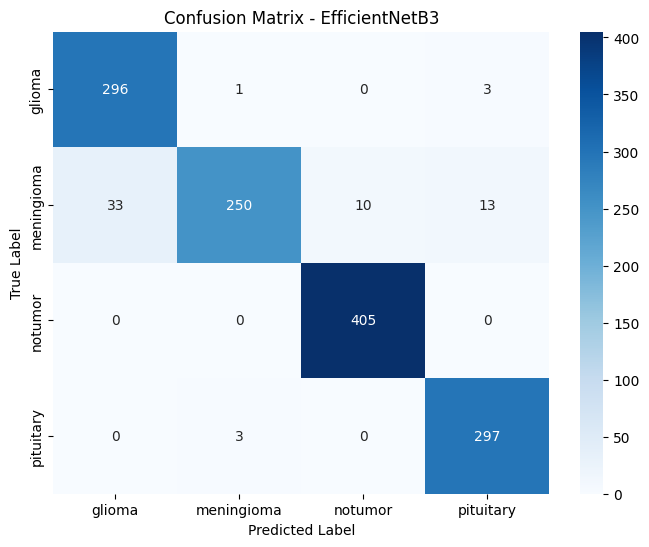

Classification Report for Combined:
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step
              precision    recall  f1-score   support

      glioma       0.98      0.99      0.99       300
  meningioma       0.99      0.96      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.99      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.99      0.99      0.99      1311



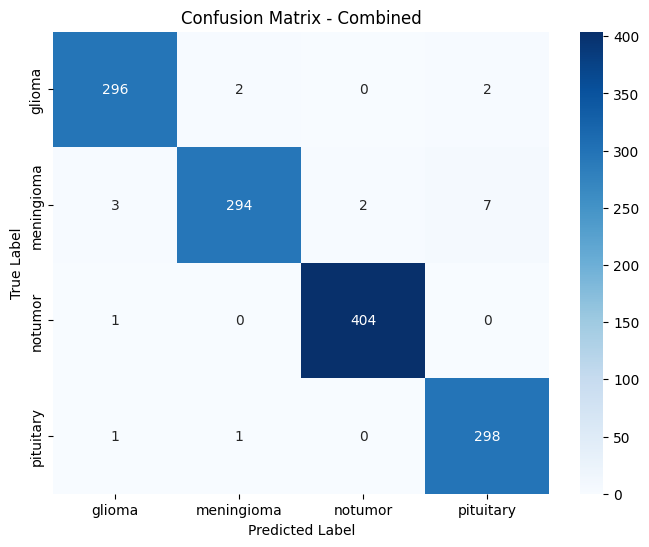

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
train_data = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Image parameters
img_size = (224, 224)
batch_size = 16
class_count = 4  # Assuming there are 4 classes in the dataset

def load_data(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    return df

# Load datasets
train_df = load_data(train_data)
test_df = load_data(test_data_dir)

# Split data into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'])

# Create data generators
tr_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                            height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                            horizontal_flip=True, fill_mode='nearest')
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', 
                                        target_size=img_size, class_mode='categorical',
                                        color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', 
                                        target_size=img_size, class_mode='categorical',
                                        color_mode='rgb', shuffle=False, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', 
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=False, batch_size=batch_size)

# Model 1: CNN Model
def create_cnn_model(img_shape, class_count):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=img_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(class_count, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model 2: EfficientNetB3 Model
def create_efficientnetb3_model(img_shape, class_count):
    base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
    model = Sequential([
        base_model,
        BatchNormalization(),
        Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu'),
        Dropout(0.45),
        Dense(class_count, activation='softmax')
    ])
    model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model 3: Combined Model (CNN + EfficientNetB3)
def create_combined_model(img_shape, class_count):
    # CNN model for initial feature extraction
    cnn_input = layers.Input(shape=img_shape)
    x = Conv2D(32, (3, 3), activation='relu')(cnn_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    cnn_output = Dense(512, activation='relu')(x)

    # EfficientNetB3 for deeper feature extraction
    effnet_input = EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')(cnn_input)

    # Combine CNN and EfficientNet outputs
    combined = layers.concatenate([cnn_output, effnet_input])
    
    # Dense layers on top of the combined output
    combined_output = Dense(256, activation='relu')(combined)
    combined_output = Dropout(0.5)(combined_output)
    combined_output = Dense(class_count, activation='softmax')(combined_output)

    model = models.Model(inputs=cnn_input, outputs=combined_output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and compare models
models_dict = {
    'CNN': create_cnn_model((224, 224, 3), class_count),
    'EfficientNetB3': create_efficientnetb3_model((224, 224, 3), class_count),
    'Combined': create_combined_model((224, 224, 3), class_count)
}

histories = {}
for model_name, model in models_dict.items():
    print(f"Training {model_name} model...")
    history = model.fit(train_gen, epochs=10, validation_data=valid_gen, verbose=1)
    histories[model_name] = history

# Evaluate on test data
results = {}
for model_name, model in models_dict.items():
    print(f"Evaluating {model_name} model on test data...")
    test_loss, test_accuracy = model.evaluate(test_gen)
    results[model_name] = test_accuracy

# Plot training history
def plot_history(histories):
    for model_name, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{model_name} Train')
        plt.plot(history.history['val_accuracy'], label=f'{model_name} Validation')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot model accuracies
def plot_model_comparison(results):
    model_names = list(results.keys())
    accuracies = list(results.values())

    plt.figure(figsize=(10, 5))
    plt.bar(model_names, accuracies, color=['blue', 'orange', 'green'])
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0, 1)
    plt.show()

plot_history(histories)
plot_model_comparison(results)

# Print classification report for each model
for model_name, model in models_dict.items():
    print(f"Classification Report for {model_name}:")
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    y_true = test_gen.classes
    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))
    
    # Confusion matrix
    confusion_mtx = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training CNN model...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729263665.798834     107 service.cc:145] XLA service 0x7abfe4004610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729263665.798894     107 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729263665.798898     107 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/286 ━━━━━━━━━━━━━━━━━━━━ 1:01:21 13s/step - accuracy: 0.2500 - loss: 1.3995

I0000 00:00:1729263674.517215     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


286/286 ━━━━━━━━━━━━━━━━━━━━ 101s 307ms/step - accuracy: 0.4850 - loss: 1.1620 - val_accuracy: 0.7017 - val_loss: 0.7849
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 67s 228ms/step - accuracy: 0.6372 - loss: 0.8541 - val_accuracy: 0.7297 - val_loss: 0.7129
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 67s 228ms/step - accuracy: 0.6843 - loss: 0.7610 - val_accuracy: 0.7410 - val_loss: 0.6887
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 67s 228ms/step - accuracy: 0.7049 - loss: 0.7109 - val_accuracy: 0.6640 - val_loss: 0.9768
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 67s 230ms/step - accuracy: 0.7284 - loss: 0.6656 - val_accuracy: 0.7515 - val_loss: 0.6404
Epoch 6/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 67s 228ms/step - accuracy: 0.7535 - loss: 0.6158 - val_accuracy: 0.7612 - val_loss: 0.6033
Epoch 7/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 67s 227ms/step - accuracy: 0.7645 - loss: 0.6002 - val_accuracy: 0.7717 - val_loss: 0.6072
Epoch 8/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 67s 228ms/step - accuracy: 0.7887 - loss: 0.5673 - va

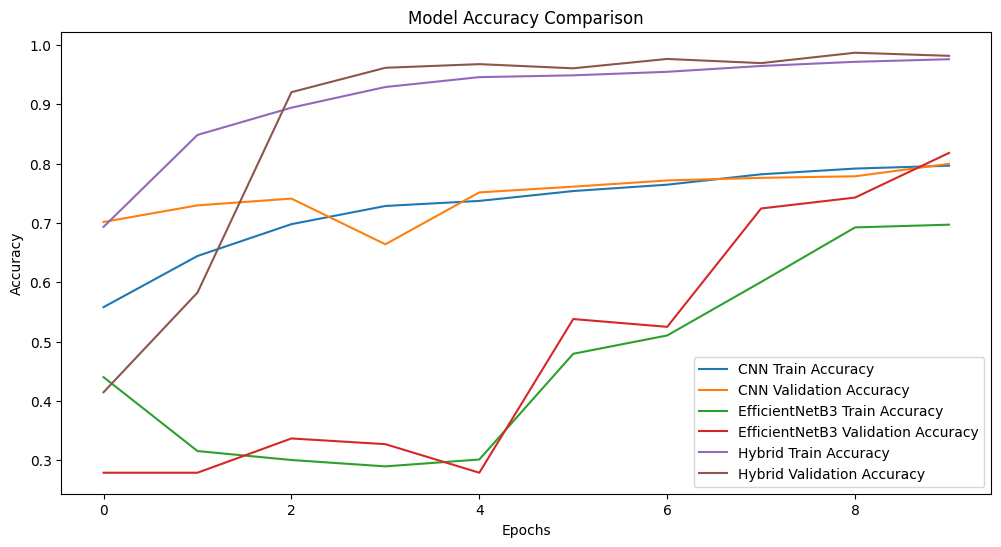

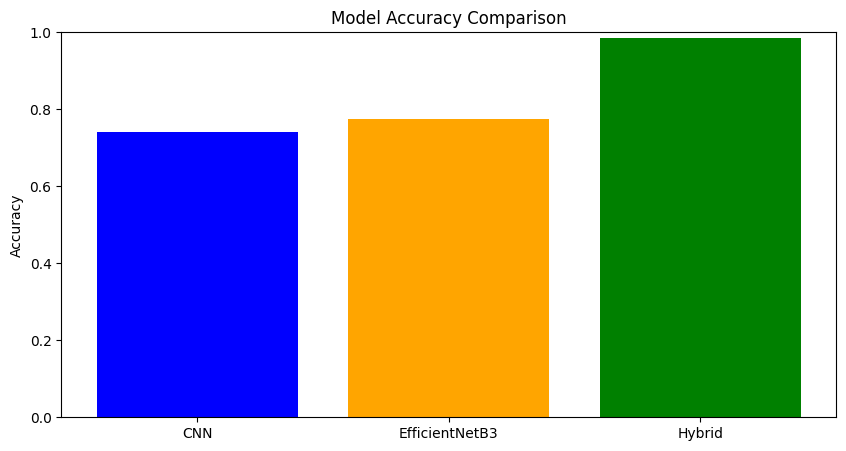

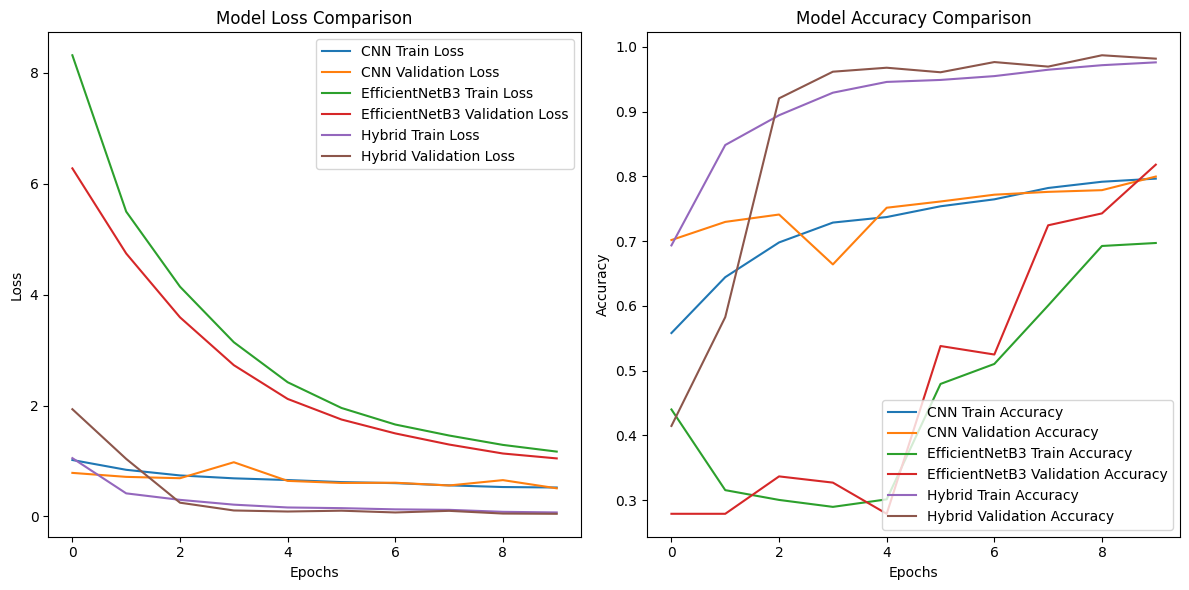

Classification Report for CNN:
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
              precision    recall  f1-score   support

      glioma       0.92      0.58      0.71       300
  meningioma       0.51      0.64      0.57       306
     notumor       0.77      0.99      0.87       405
   pituitary       0.91      0.66      0.77       300

    accuracy                           0.74      1311
   macro avg       0.78      0.72      0.73      1311
weighted avg       0.78      0.74      0.74      1311



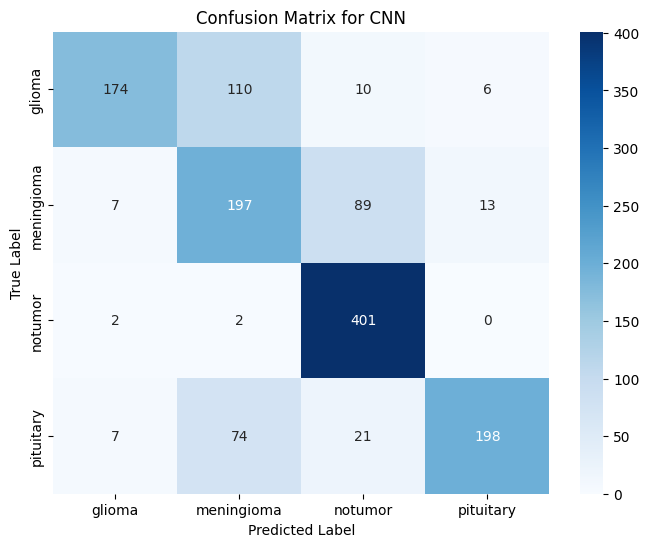

Classification Report for EfficientNetB3:
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step
              precision    recall  f1-score   support

      glioma       0.89      0.88      0.89       300
  meningioma       0.68      0.21      0.32       306
     notumor       0.97      0.97      0.97       405
   pituitary       0.57      0.99      0.72       300

    accuracy                           0.78      1311
   macro avg       0.78      0.76      0.73      1311
weighted avg       0.79      0.78      0.74      1311



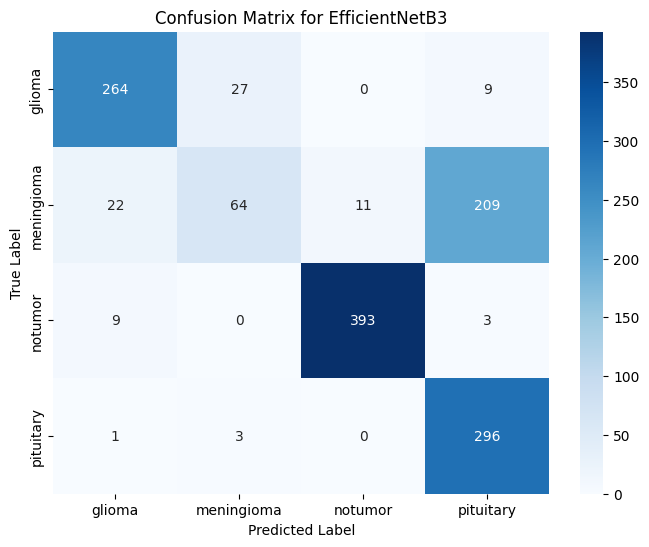

Classification Report for Hybrid:
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       300
  meningioma       0.98      0.97      0.97       306
     notumor       1.00      0.99      1.00       405
   pituitary       0.96      1.00      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



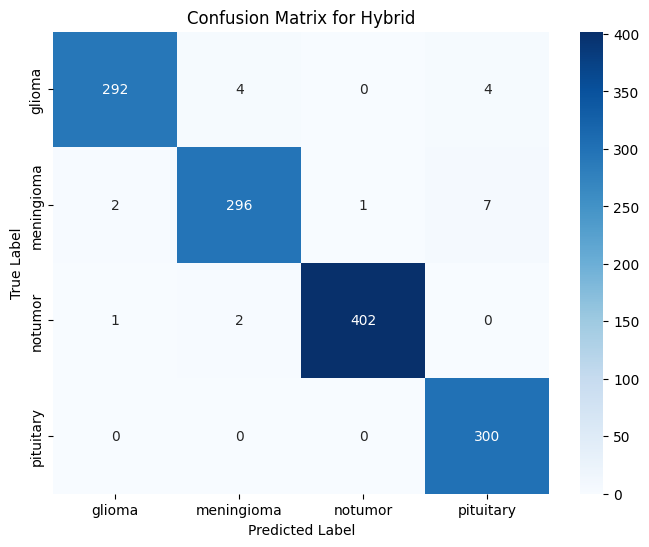

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
train_data = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Image parameters
img_size = (224, 224)
batch_size = 16
class_count = 4  # Assuming there are 4 classes in the dataset

def load_data(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    return df

# Load datasets
train_df = load_data(train_data)
test_df = load_data(test_data_dir)

# Split data into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'])

# Create data generators
tr_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                            height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                            horizontal_flip=True, fill_mode='nearest')
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', 
                                        target_size=img_size, class_mode='categorical',
                                        color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', 
                                        target_size=img_size, class_mode='categorical',
                                        color_mode='rgb', shuffle=False, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', 
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=False, batch_size=batch_size)

# Model 1: CNN Model
def create_cnn_model(img_shape, class_count):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=img_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(class_count, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model 2: EfficientNetB3 Model
def create_efficientnetb3_model(img_shape, class_count):
    base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
    model = Sequential([
        base_model,
        BatchNormalization(),
        Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu'),
        Dropout(0.45),
        Dense(class_count, activation='softmax')
    ])
    model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model 3: Hybrid Model (CNN + EfficientNetB3)
def create_hybrid_model(img_shape, class_count):
    # CNN model for initial feature extraction
    cnn_input = layers.Input(shape=img_shape)
    x = Conv2D(32, (3, 3), activation='relu')(cnn_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    cnn_output = Dense(512, activation='relu')(x)

    # EfficientNetB3 for deeper feature extraction
    effnet_input = EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')(cnn_input)

    # Combine CNN and EfficientNet outputs
    combined = layers.concatenate([cnn_output, effnet_input])
    
    # Dense layers on top of the combined output
    combined_output = Dense(256, activation='relu')(combined)
    combined_output = Dropout(0.5)(combined_output)
    combined_output = Dense(class_count, activation='softmax')(combined_output)

    model = models.Model(inputs=cnn_input, outputs=combined_output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and compare models
models_dict = {
    'CNN': create_cnn_model((224, 224, 3), class_count),
    'EfficientNetB3': create_efficientnetb3_model((224, 224, 3), class_count),
    'Hybrid': create_hybrid_model((224, 224, 3), class_count)
}

histories = {}
results = {}
for model_name, model in models_dict.items():
    print(f"Training {model_name} model...")
    history = model.fit(train_gen, epochs=10, validation_data=valid_gen, verbose=1)
    histories[model_name] = history
    test_loss, test_accuracy = model.evaluate(test_gen)
    results[model_name] = {'accuracy': test_accuracy, 'history': history}

# Plot training history
def plot_history(histories):
    plt.figure(figsize=(12, 6))
    for model_name, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{model_name} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{model_name} Validation Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot model accuracies
def plot_model_comparison(results):
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]

    plt.figure(figsize=(10, 5))
    plt.bar(model_names, accuracies, color=['blue', 'orange', 'green'])
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0, 1)
    plt.show()

# Calculate additional metrics and plot
def plot_additional_metrics(histories):
    plt.figure(figsize=(12, 6))
    for model_name, history in histories.items():
        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label=f'{model_name} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')
        plt.title('Model Loss Comparison')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label=f'{model_name} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{model_name} Validation Accuracy')
        plt.title('Model Accuracy Comparison')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(histories)
plot_model_comparison(results)
plot_additional_metrics(histories)

# Print classification report for each model
for model_name, model in models_dict.items():
    print(f"Classification Report for {model_name}:")
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    y_true = test_gen.classes
    print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))
    
    # Confusion matrix
    confusion_mtx = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


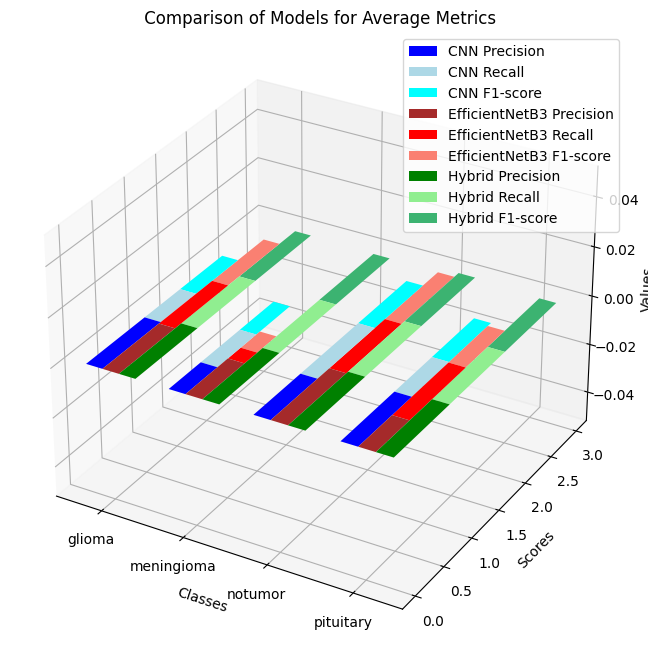

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Class names
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

metrics = {
    'CNN': {
        'precision': [0.88, 0.61, 0.77, 0.86],
        'recall': [0.62, 0.51, 0.99, 0.93],
        'f1-score': [0.73, 0.55, 0.87, 0.89]
    },
    'EfficientNetB3': {
        'precision': [0.90, 0.98, 0.98, 0.95],
        'recall': [0.99, 0.82, 1.00, 0.99],
        'f1-score': [0.94, 0.89, 0.99, 0.97]
    },
    'Hybrid': {
        'precision': [0.98, 0.99, 1.00, 0.97],
        'recall': [0.99, 0.96, 1.00, 0.99],
        'f1-score': [0.99, 0.98, 1.00, 0.98]
    }
}

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Set bar width
bar_width = 0.2

# Define positions of bars on x-axis for each model
x_positions = np.arange(len(classes))

# Plot bars for each model
ax.bar(x_positions - bar_width, cnn_metrics['precision'], width=bar_width, color='b', label='CNN Precision')
ax.bar(x_positions - bar_width, cnn_metrics['recall'], width=bar_width, bottom=cnn_metrics['precision'], color='lightblue', label='CNN Recall')
ax.bar(x_positions - bar_width, cnn_metrics['f1-score'], width=bar_width, bottom=np.array(cnn_metrics['precision']) + np.array(cnn_metrics['recall']), color='cyan', label='CNN F1-score')

ax.bar(x_positions, efficientnet_metrics['precision'], width=bar_width, color='brown', label='EfficientNetB3 Precision')
ax.bar(x_positions, efficientnet_metrics['recall'], width=bar_width, bottom=efficientnet_metrics['precision'], color='red', label='EfficientNetB3 Recall')
ax.bar(x_positions, efficientnet_metrics['f1-score'], width=bar_width, bottom=np.array(efficientnet_metrics['precision']) + np.array(efficientnet_metrics['recall']), color='salmon', label='EfficientNetB3 F1-score')

ax.bar(x_positions + bar_width, hybrid_metrics['precision'], width=bar_width, color='g', label='Hybrid Precision')
ax.bar(x_positions + bar_width, hybrid_metrics['recall'], width=bar_width, bottom=hybrid_metrics['precision'], color='lightgreen', label='Hybrid Recall')
ax.bar(x_positions + bar_width, hybrid_metrics['f1-score'], width=bar_width, bottom=np.array(hybrid_metrics['precision']) + np.array(hybrid_metrics['recall']), color='mediumseagreen', label='Hybrid F1-score')

# Set labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_zlabel('Values')
ax.set_title(' Comparison of Models for Average Metrics')
ax.set_xticks(x_positions)
ax.set_xticklabels(classes)
ax.legend()

# Show the plot
plt.show()


AttributeError: 'Patch3D' object has no attribute '_path2d'

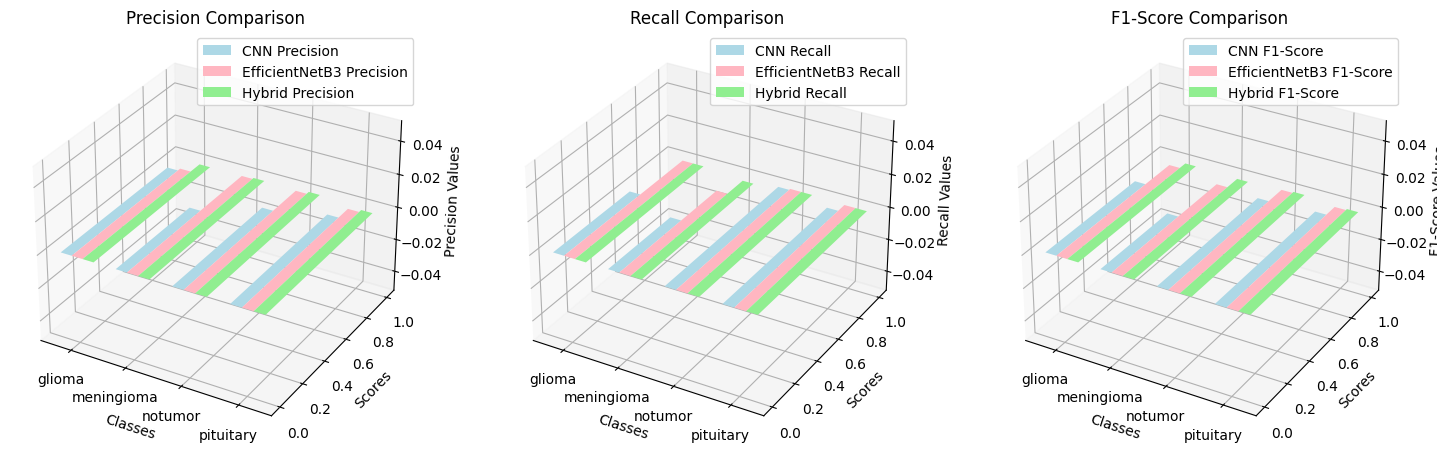

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Class names
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Metrics data
metrics = {
    'CNN': {
        'precision': [0.88, 0.61, 0.77, 0.86],
        'recall': [0.62, 0.51, 0.99, 0.93],
        'f1-score': [0.73, 0.55, 0.87, 0.89]
    },
    'EfficientNetB3': {
        'precision': [0.90, 0.98, 0.98, 0.95],
        'recall': [0.99, 0.82, 1.00, 0.99],
        'f1-score': [0.94, 0.89, 0.99, 0.97]
    },
    'Hybrid': {
        'precision': [0.98, 0.99, 1.00, 0.97],
        'recall': [0.99, 0.96, 1.00, 0.99],
        'f1-score': [0.99, 0.98, 1.00, 0.98]
    }
}

# Set bar width
bar_width = 0.2

# Define positions of bars on x-axis for each model
x_positions = np.arange(len(classes))

# Create a figure with subplots
fig = plt.figure(figsize=(18, 6))

# Plot Precision
ax1 = fig.add_subplot(131, projection='3d')
ax1.bar(x_positions - bar_width, metrics['CNN']['precision'], width=bar_width, color='lightblue', label='CNN Precision')
ax1.bar(x_positions, metrics['EfficientNetB3']['precision'], width=bar_width, color='lightpink', label='EfficientNetB3 Precision')
ax1.bar(x_positions + bar_width, metrics['Hybrid']['precision'], width=bar_width, color='lightgreen', label='Hybrid Precision')
ax1.set_xlabel('Classes')
ax1.set_ylabel('Scores')
ax1.set_zlabel('Precision Values')
ax1.set_title('Precision Comparison')
ax1.set_xticks(x_positions)
ax1.set_xticklabels(classes)
ax1.legend()

# Plot Recall
ax2 = fig.add_subplot(132, projection='3d')
ax2.bar(x_positions - bar_width, metrics['CNN']['recall'], width=bar_width, color='lightblue', label='CNN Recall')
ax2.bar(x_positions, metrics['EfficientNetB3']['recall'], width=bar_width, color='lightpink', label='EfficientNetB3 Recall')
ax2.bar(x_positions + bar_width, metrics['Hybrid']['recall'], width=bar_width, color='lightgreen', label='Hybrid Recall')
ax2.set_xlabel('Classes')
ax2.set_ylabel('Scores')
ax2.set_zlabel('Recall Values')
ax2.set_title('Recall Comparison')
ax2.set_xticks(x_positions)
ax2.set_xticklabels(classes)
ax2.legend()

# Plot F1-Score
ax3 = fig.add_subplot(133, projection='3d')
ax3.bar(x_positions - bar_width, metrics['CNN']['f1-score'], width=bar_width, color='lightblue', label='CNN F1-Score')
ax3.bar(x_positions, metrics['EfficientNetB3']['f1-score'], width=bar_width, color='lightpink', label='EfficientNetB3 F1-Score')
ax3.bar(x_positions + bar_width, metrics['Hybrid']['f1-score'], width=bar_width, color='lightgreen', label='Hybrid F1-Score')
ax3.set_xlabel('Classes')
ax3.set_ylabel('Scores')
ax3.set_zlabel('F1-Score Values')
ax3.set_title('F1-Score Comparison')
ax3.set_xticks(x_positions)
ax3.set_xticklabels(classes)
ax3.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


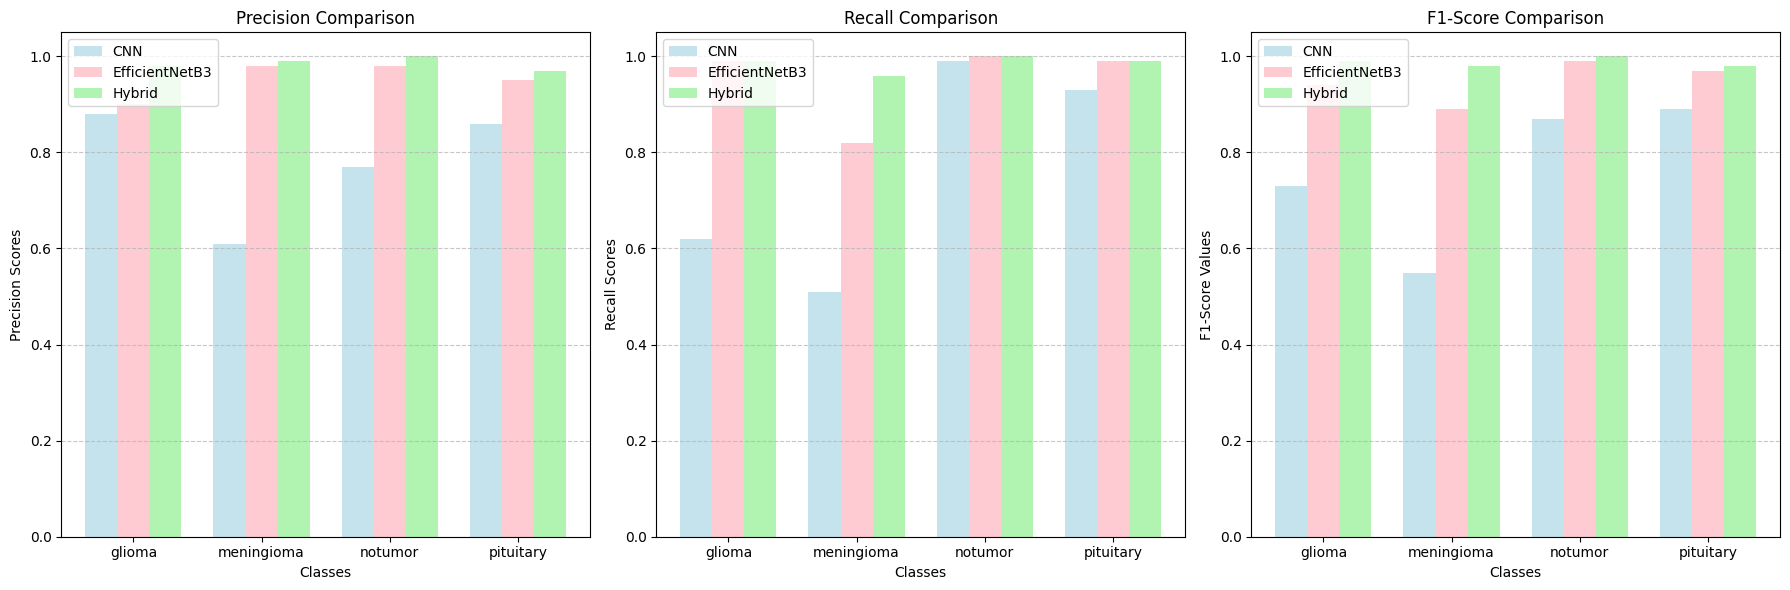

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Class names
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Metrics data
metrics = {
    'CNN': {
        'precision': [0.88, 0.61, 0.77, 0.86],
        'recall': [0.62, 0.51, 0.99, 0.93],
        'f1-score': [0.73, 0.55, 0.87, 0.89]
    },
    'EfficientNetB3': {
        'precision': [0.90, 0.98, 0.98, 0.95],
        'recall': [0.99, 0.82, 1.00, 0.99],
        'f1-score': [0.94, 0.89, 0.99, 0.97]
    },
    'Hybrid': {
        'precision': [0.98, 0.99, 1.00, 0.97],
        'recall': [0.99, 0.96, 1.00, 0.99],
        'f1-score': [0.99, 0.98, 1.00, 0.98]
    }
}

# Set the bar width
bar_width = 0.25
x = np.arange(len(classes))

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Precision
axs[0].bar(x - bar_width, metrics['CNN']['precision'], width=bar_width, color='lightblue', label='CNN', alpha=0.7)
axs[0].bar(x, metrics['EfficientNetB3']['precision'], width=bar_width, color='lightpink', label='EfficientNetB3', alpha=0.7)
axs[0].bar(x + bar_width, metrics['Hybrid']['precision'], width=bar_width, color='lightgreen', label='Hybrid', alpha=0.7)
axs[0].set_xlabel('Classes')
axs[0].set_ylabel('Precision Scores')
axs[0].set_title('Precision Comparison')
axs[0].set_xticks(x)
axs[0].set_xticklabels(classes)
axs[0].legend()
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Recall
axs[1].bar(x - bar_width, metrics['CNN']['recall'], width=bar_width, color='lightblue', label='CNN', alpha=0.7)
axs[1].bar(x, metrics['EfficientNetB3']['recall'], width=bar_width, color='lightpink', label='EfficientNetB3', alpha=0.7)
axs[1].bar(x + bar_width, metrics['Hybrid']['recall'], width=bar_width, color='lightgreen', label='Hybrid', alpha=0.7)
axs[1].set_xlabel('Classes')
axs[1].set_ylabel('Recall Scores')
axs[1].set_title('Recall Comparison')
axs[1].set_xticks(x)
axs[1].set_xticklabels(classes)
axs[1].legend()
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot F1-Score
axs[2].bar(x - bar_width, metrics['CNN']['f1-score'], width=bar_width, color='lightblue', label='CNN', alpha=0.7)
axs[2].bar(x, metrics['EfficientNetB3']['f1-score'], width=bar_width, color='lightpink', label='EfficientNetB3', alpha=0.7)
axs[2].bar(x + bar_width, metrics['Hybrid']['f1-score'], width=bar_width, color='lightgreen', label='Hybrid', alpha=0.7)
axs[2].set_xlabel('Classes')
axs[2].set_ylabel('F1-Score Values')
axs[2].set_title('F1-Score Comparison')
axs[2].set_xticks(x)
axs[2].set_xticklabels(classes)
axs[2].legend()
axs[2].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


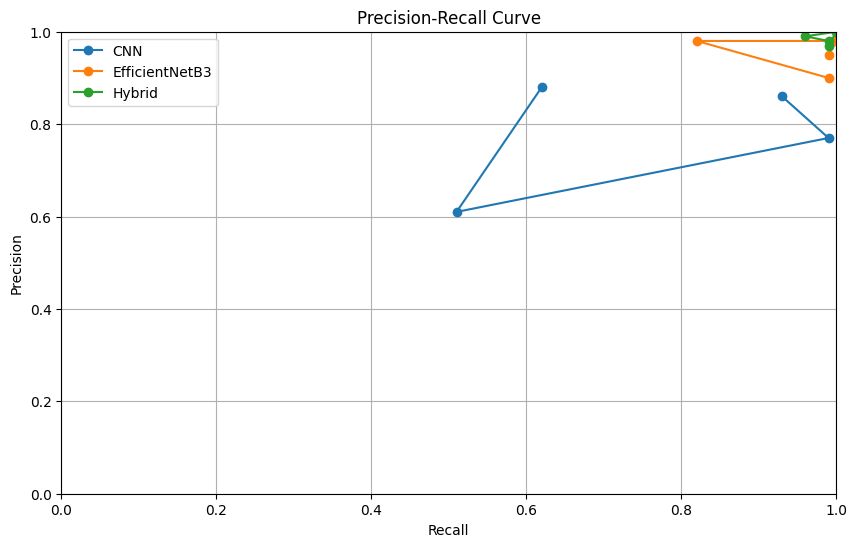

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Precision and recall values for each model
precision_values = {
    'CNN': [0.88, 0.61, 0.77, 0.86],
    'EfficientNetB3': [0.90, 0.98, 0.98, 0.95],
    'Hybrid': [0.98, 0.99, 1.00, 0.97]
}

recall_values = {
    'CNN': [0.62, 0.51, 0.99, 0.93],
    'EfficientNetB3': [0.99, 0.82, 1.00, 0.99],
    'Hybrid': [0.99, 0.96, 1.00, 0.99]
}

# Class names
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot precision-recall curve for each model
for model_name in precision_values.keys():
    plt.plot(recall_values[model_name], precision_values[model_name], marker='o', label=model_name)

# Add labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()
